# DVE Exam
## Matthew Dacre 2091295

In [1]:
import pandas as pd
import missingno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.svm import SVC
import time
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.manifold import Isomap

# Question 1

In [2]:
insurance_df = pd.read_csv('./datasets_2022/insurance.csv')

insurance_df.head()

,age,sex,bmi,children,smoker,region,charges,premium
0,19,female,27.900,0,yes,southwest,16884.92400,350
1,18,male,33.770,1,no,southeast,1725.55230,200
2,28,male,33.000,3,no,southeast,4449.46200,100
3,33,male,22.705,0,no,northwest,21984.47061,200
4,32,male,28.880,0,no,northwest,3866.85520,350


## Question 1.1

#### 1.1.1

In [3]:
insurance_df.describe()

,age,bmi,children,charges,premium
count,1353.000000,1353.000000,1353.000000,1338.000000,1353.000000
mean,39.157428,30.670080,1.118256,13270.422265,287.730968
std,14.021578,6.093331,1.229290,12110.011237,152.363854
min,18.000000,15.960000,0.000000,1121.873900,100.000000
25%,26.000000,26.290000,0.000000,4740.287150,100.000000
50%,39.000000,30.400000,1.000000,9382.033000,350.000000
75%,51.000000,34.700000,2.000000,16639.912515,500.000000
max,64.000000,53.130000,5.000000,63770.428010,500.000000


In [4]:
insurance_df.describe(include=['O'])

,sex,smoker,region
count,1353,1338,1353
unique,2,2,4
top,male,no,southeast
freq,680,1064,369


#### 1.1.2

In [7]:
insurance_df.duplicated().value_counts()

False    1353
dtype: int64

As can be seen above, there are no duplicate rows in the data set

In [5]:
insurance_df.isna().sum()

age          0
sex          0
bmi          0
children     0
smoker      15
region       0
charges     15
premium      0
dtype: int64

From above, we can see that there are 15 missing valaues for charges and smoker. The cell below checks to see if they are the same or different records.

In [6]:
print("Are the missing records common across columns: ", insurance_df[insurance_df.smoker.isna()]['charges'].isna().sum() == 15)

Are the missing records common across columns:  True


Printing these records to evaluate if they need to be dropped or imputed

In [7]:
print((len(insurance_df[insurance_df.smoker.isna()])/len(insurance_df))*100, "%")

insurance_df[insurance_df.smoker.isna()]

1.1086474501108647 %


,age,sex,bmi,children,smoker,region,charges,premium
1338,36,female,31.344096,2,NaN,southeast,NaN,200
1339,26,female,39.145120,2,NaN,northwest,NaN,500
1340,52,male,33.293596,3,NaN,northeast,NaN,200
1341,45,female,24.350606,2,NaN,northwest,NaN,200
1342,24,female,25.913477,5,NaN,northeast,NaN,350
1343,37,female,20.042088,5,NaN,southeast,NaN,200
1344,47,male,29.236661,4,NaN,southeast,NaN,500
1345,32,female,30.142417,1,NaN,southeast,NaN,500
1346,43,female,36.810516,5,NaN,southeast,NaN,500
1347,23,female,38.295417,1,NaN,northwest,NaN,200


Because charges it is the target variable, we probably do not want to impute it, as this could affect the accuracy of our precisions. It also only makes up about 1% of the total records, and so they will be dropped from the data.

In [8]:
insurance_df.dropna(axis=0, how='any', inplace=True)

#### 1.1.3

Sex will be converted to a boolean value where True = Male. Smoker will be converted to a boolean value. Region will remain as a catagorical value and will be converted to a string dtype.

In [9]:
insurance_df['sex'] = np.where(insurance_df['sex'] == 'male', True, False)
insurance_df['smoker'] = np.where(insurance_df['smoker'] == 'yes', True, False)
insurance_df['region'] = insurance_df['region'].astype(pd.StringDtype())

insurance_df.dtypes

age           int64
sex            bool
bmi         float64
children      int64
smoker         bool
region       string
charges     float64
premium       int64
dtype: object

## Question 1.2

#### 1.2.4

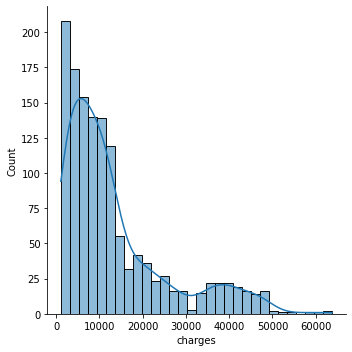

In [11]:
_ = sns.displot(insurance_df, x='charges', kde=True)

The majority of charges are below 10-15 thousand USD. There is an uptick in charges around 40 thousand USD, which is likely due to expensive treatment obtained by the clients. The tail of charges past 50 thousand USD may be outliers, but this would have to be compared to records with similar other features to confirm this as in the US, procedures more than 50-60 thousand USD are not as unlikely in other countries. Some of the charges more than 60 thousand USD may be outliers, but not significantly so.

#### 1.2.5

In [12]:
# Try do with bool variables
print("Full correlation matrix:")
print(insurance_df.corr())
print("Just correlation with charges:")
print(insurance_df.corr()['charges'])

Full correlation matrix:
               age       sex       bmi  children    smoker   charges   premium
age       1.000000 -0.020856  0.109272  0.042469 -0.025019  0.299008  0.018450
sex      -0.020856  1.000000  0.046371  0.017163  0.076185  0.057292  0.053840
bmi       0.109272  0.046371  1.000000  0.012759  0.003750  0.198341  0.006605
children  0.042469  0.017163  0.012759  1.000000  0.007673  0.067998 -0.013861
smoker   -0.025019  0.076185  0.003750  0.007673  1.000000  0.787251  0.001098
charges   0.299008  0.057292  0.198341  0.067998  0.787251  1.000000  0.028325
premium   0.018450  0.053840  0.006605 -0.013861  0.001098  0.028325  1.000000
Just correlation with charges:
age         0.299008
sex         0.057292
bmi         0.198341
children    0.067998
smoker      0.787251
charges     1.000000
premium     0.028325
Name: charges, dtype: float64


There appears to be a correlation between charges and age with a score of 0.3, and as well with bmi which has a score of 0.2. The most correlated variable is `smoker`, with a correlation of 0.78.

#### 1.2.6

C:\Users\Matthew Dacre\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Matthew Dacre\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Matthew Dacre\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function wit

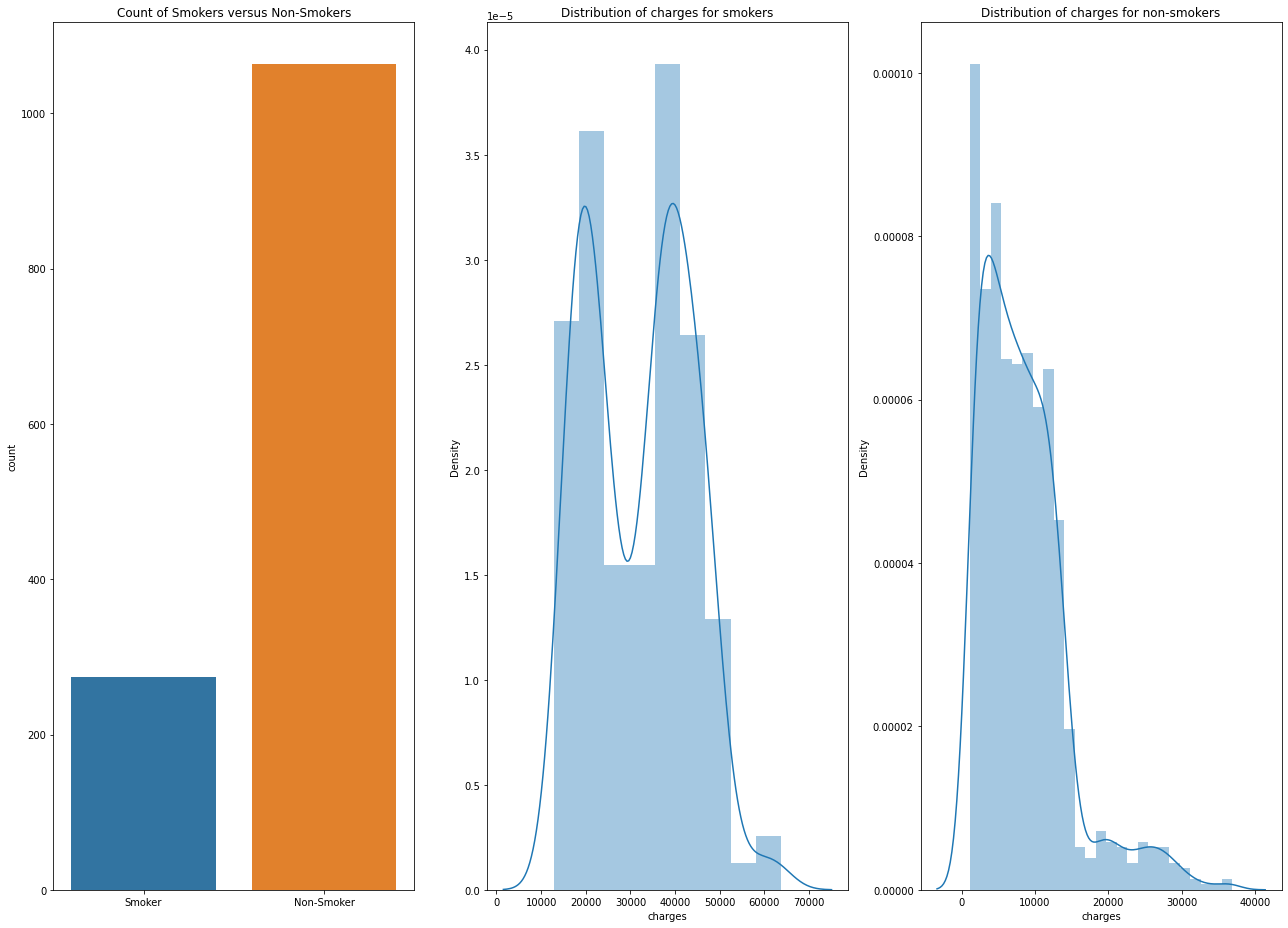

In [14]:
insurance_plot_df = np.where(insurance_df['smoker'] == True, "Smoker", "Non-Smoker")

fig, axs = plt.subplots(1, 3, figsize=(18, 13))
ax = axs.ravel()

sns.countplot(insurance_plot_df, ax=ax[0])
ax[0].set_title("Count of Smokers versus Non-Smokers")

sns.distplot(insurance_df[insurance_df['smoker'] == True]['charges'], kde=True, ax=ax[1])
ax[1].set_title("Distribution of charges for smokers")

sns.distplot(insurance_df[insurance_df['smoker'] == False]['charges'], kde=True, ax=ax[2])
ax[2].set_title("Distribution of charges for non-smokers")

fig.tight_layout()
plt.show()

For non-smokers, the majority of `charges` appears to be on the lower end, more towards the left of the plot when comapred with the smokers plot, which has two peaks much further right. This is likely due to non-smokers being less likely to contract expensive diseases such as cancer when compared to smokers. It has a tail on the right hand side of the graph which will account for the few non-smokers who need expensive operations. Non-smokers are less liekly to require very expensive procedures, resulting in a tail.

#### 1.2.7

C:\Users\Matthew Dacre\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Matthew Dacre\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Matthew Dacre\AppData\Roaming\Python\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function wit

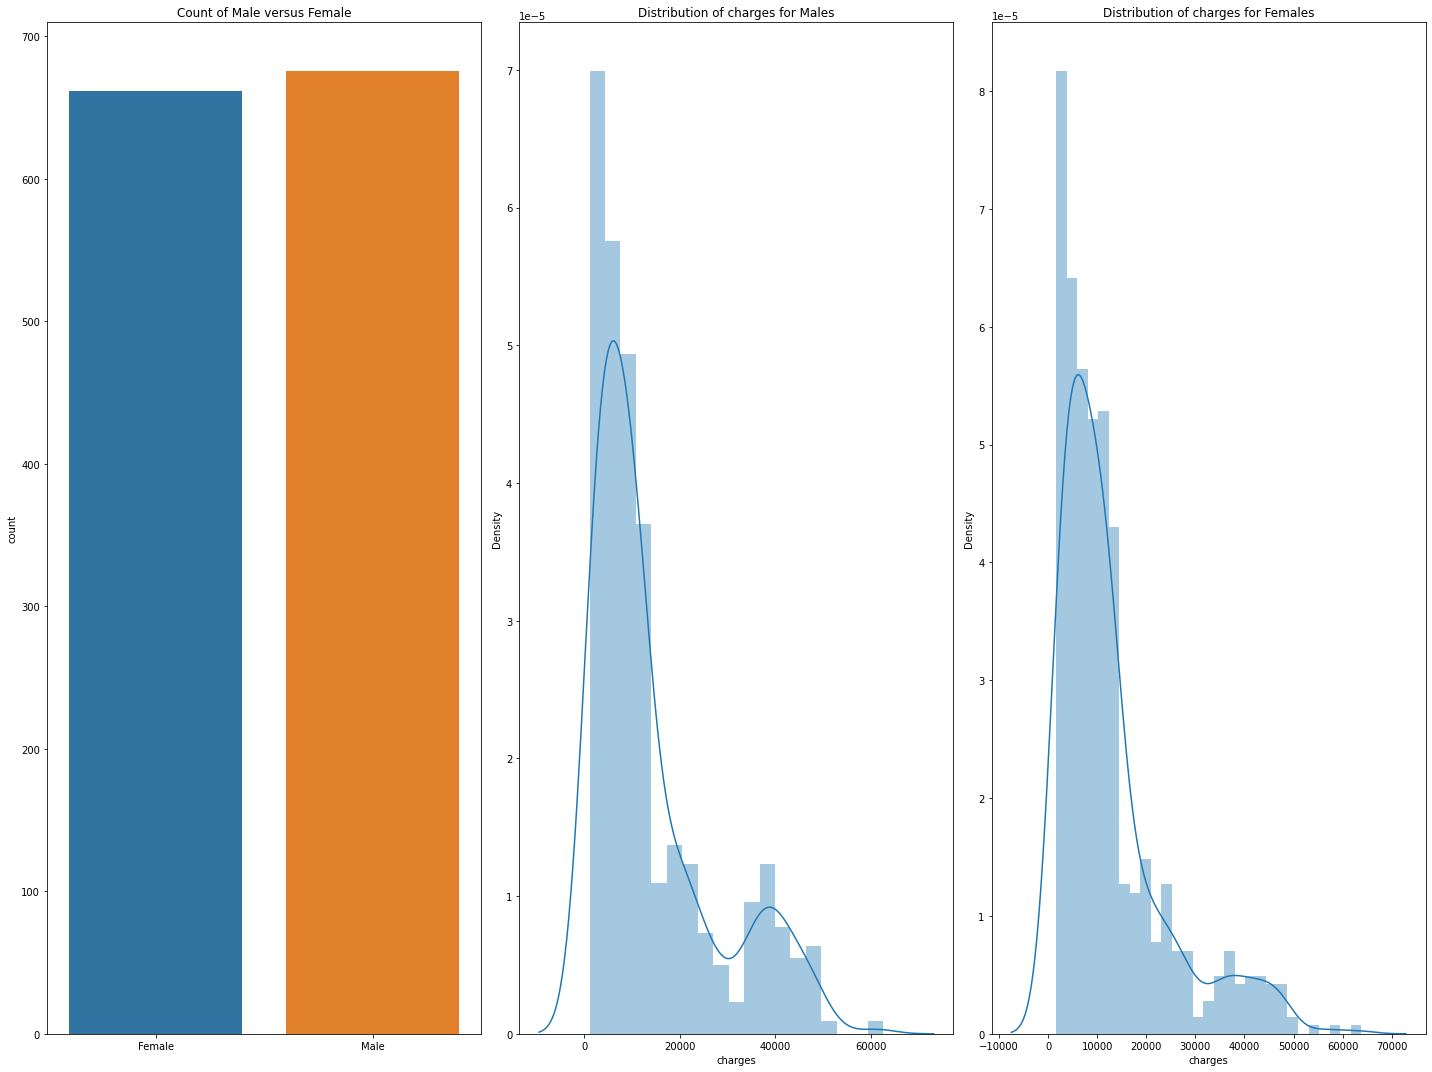

In [13]:
insurance_plot_df = np.where(insurance_df['sex'] == True, "Male", "Female")

fig, axs = plt.subplots(1, 3, figsize=(20, 15))
ax = axs.ravel()

sns.countplot(insurance_plot_df, ax=ax[0])
ax[0].set_title("Count of Male versus Female")

sns.distplot(insurance_df[insurance_df['sex'] == True]['charges'], kde=True, ax=ax[1])
ax[1].set_title("Distribution of charges for Males")

sns.distplot(insurance_df[insurance_df['sex'] == False]['charges'], kde=True, ax=ax[2])
ax[2].set_title("Distribution of charges for Females")

fig.tight_layout()

plt.show()

There appears to be very similar amount of Males and Females in the dataset, and the charges distribution appears very similar between the sexes.

#### 1.2.8

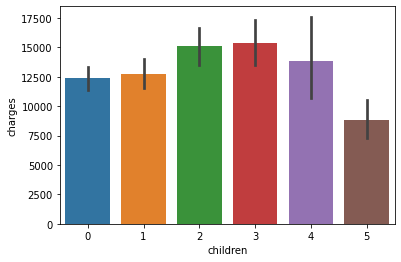

In [21]:
_ = sns.barplot(data=insurance_df, x='children', y='charges')

In [15]:
print("Percentage of records with 4 or more children:", len(insurance_df[insurance_df.children >= 4])/len(insurance_df) * 100, "%")

Percentage of records with 4 or more children: 3.2137518684603883 %


As `children` increases, the charges appear to increase. This drops off at 4 and 5 children, but this is likely due to the small amount of records for patients who had 4 and 5 children, which constitues only about 3% of the total records. Therefore, `charges` increases as children `increase`.

#### 1.2.9

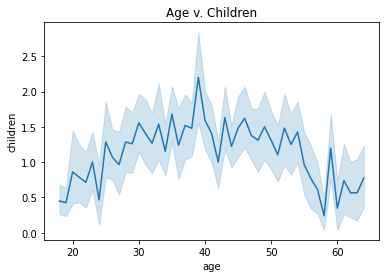

In [27]:
_ = sns.lineplot(data=insurance_df, x='age', y='children').set_title("Age v. Children")

It appears that on either end of the range of ages, the amount of children drops to on average less than on child per patient. There is a peak at age 40 where the average rises to 2 children per patient. This means that the closer a patient is to and age of 40, the more children they are liekly to have.

#### 1.2.10

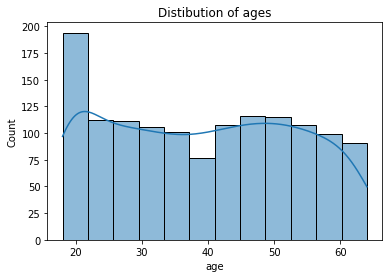

In [17]:
_ = sns.histplot(insurance_df, x='age', kde=True).set_title("Distibution of ages")

There appears to be more 20 year olds, and less 40 year olds than any other age group, where every other age group is roughly the same. 

#### 1.2.11

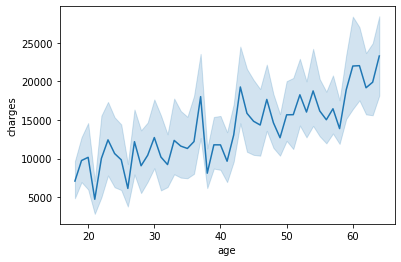

In [18]:
_ = sns.lineplot(data=insurance_df, x='age', y='charges')

It appears that insurance charges do increase by age. Other than the fact that older people are more likely to be sick, older people are also more likely to be long term smokers. It was shown before, that smokers have more average charges than non-smokers. Because smoking has only recently started being discouraged for health reasons, and was actaully encouraged in the past, it makes sense that older patients have higher average charges. Older patients might also be more liekly to have larger claims approved, as they will have had more time to be with the insurance company and have paid more premiums/gotten a better deal due to their loyalty to the company.

#### 1.2.12

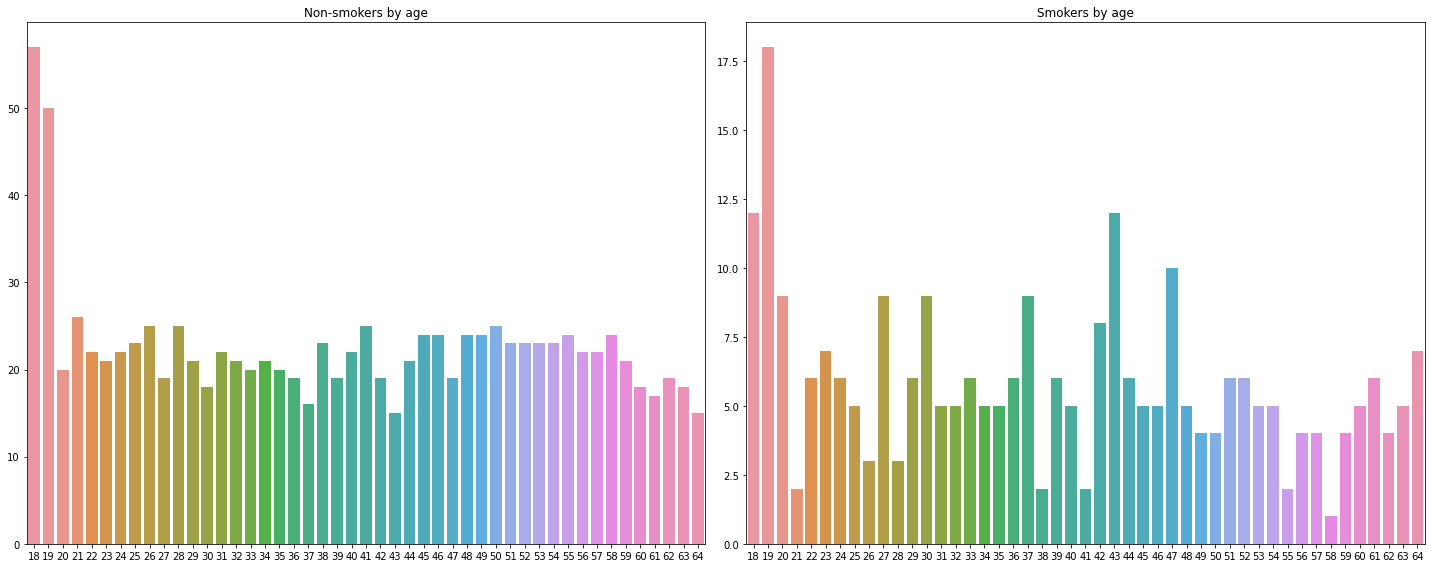

In [46]:
labels = insurance_df.groupby('age')['smoker'].value_counts().index.to_numpy()
values = insurance_df.groupby('age')['smoker'].value_counts().to_numpy()

s = []
n = []
ages = np.arange(18, 65)

for i in range(1, len(values), 2):
    n.append(values[i-1])
    s.append(values[i])

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.barplot(x=ages, y=n, ax=axs[0])
axs[0].set_title("Non-smokers by age")

sns.barplot(x=ages, y=s, ax=axs[1])
axs[1].set_title("Smokers by age")

fig.tight_layout()
plt.show()

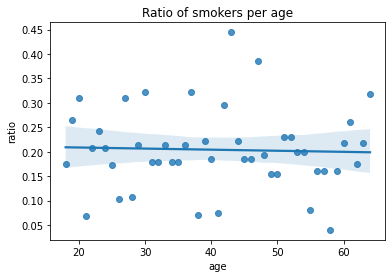

In [48]:
smoker_counts = insurance_df.groupby('age')['smoker'].sum().reset_index()
age_counts = insurance_df['age'].value_counts().reset_index()
age_counts.sort_values('index')

smoker_counts['ratio'] = smoker_counts['smoker']/age_counts['age']

_ = sns.regplot(data = smoker_counts, x='age', y='ratio').set_title('Ratio of smokers per age')

It is not obvious if there is a relationship between smoking and age. The amount of non-smokers per age appears constant, with outliers at age 18 and 19. The number of smokers seem to be essentailly random. The ratio per age does not follow any specific trend. According to this data set there is no relationship. The data set itself may be flawed as insurance claims in the US, where the majority of insurance is private, might not be representative of the total population.

#### 1.2.13

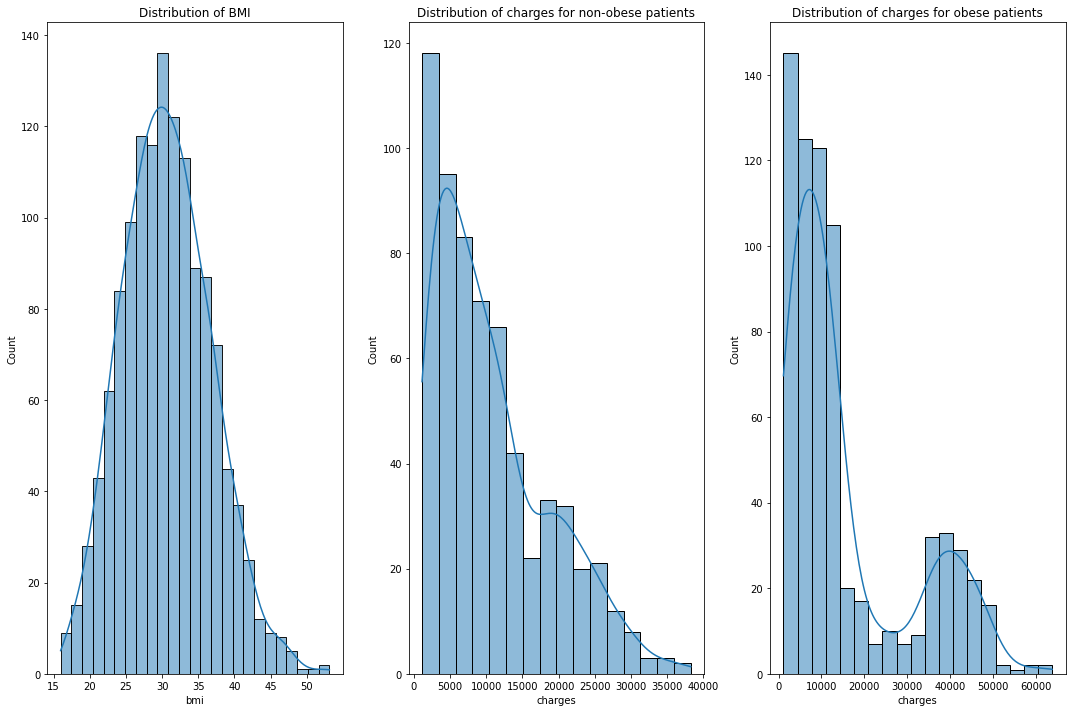

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

sns.histplot(insurance_df, x='bmi', kde=True, ax=axs[0])
axs[0].set_title("Distribution of BMI")

sns.histplot(insurance_df[insurance_df['bmi'] < 30], x='charges', kde=True, ax=axs[1])
axs[1].set_title("Distribution of charges for non-obese patients")

sns.histplot(insurance_df[insurance_df['bmi'] >= 30], x='charges', kde=True, ax=axs[2])
axs[2].set_title("Distribution of charges for obese patients")

fig.tight_layout()
plt.show()


At least half of BMI values are $>= 30$, meaning that most of the patients whos records were collected are classified as obese (https://www.cdc.gov/obesity/basics/adult-defining.html) according to the US definintion. Clients who are obese have more high charges, with a peak in the 40 - 50 thousand USD range when compared to non-obese clients. 

#### 1.2.14

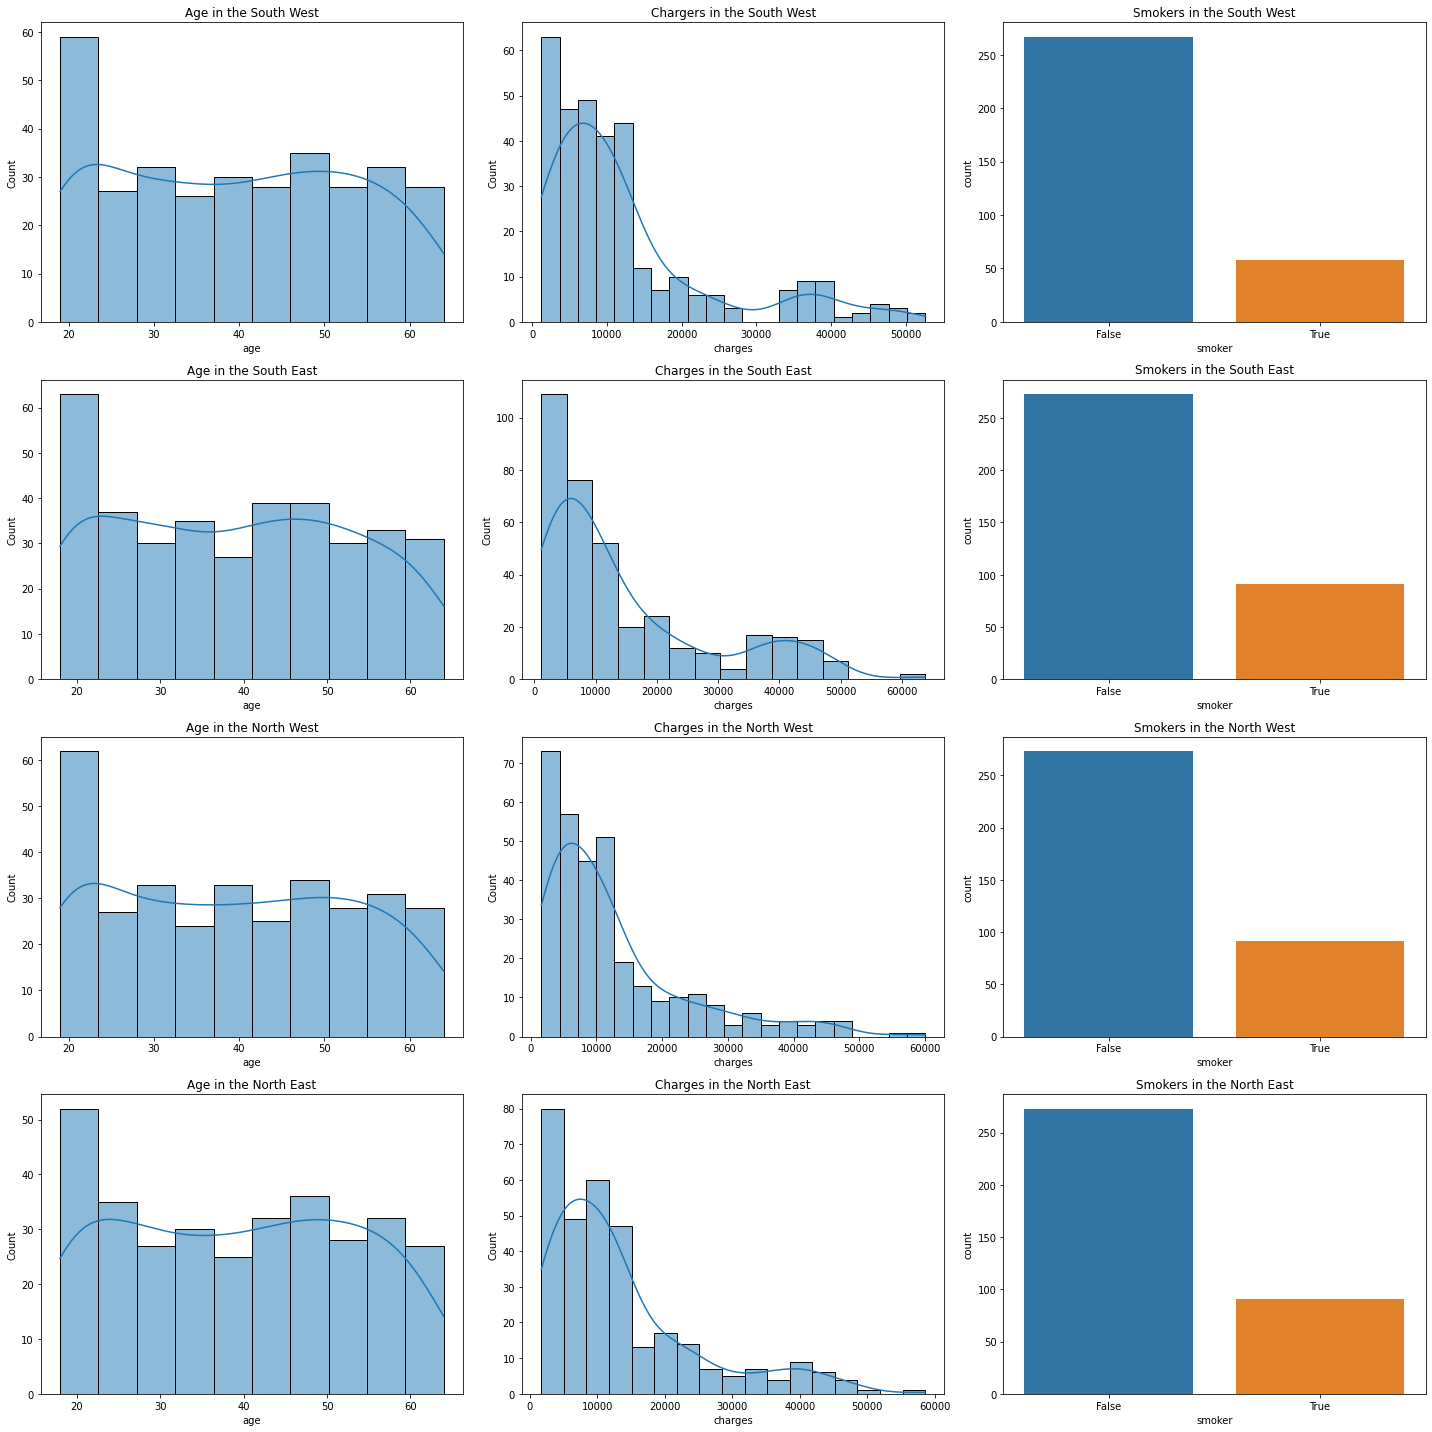

In [49]:
sw = insurance_df[insurance_df['region'] == 'southwest']
se = insurance_df[insurance_df['region'] == 'southeast']
nw = insurance_df[insurance_df['region'] == 'northwest']
ne = insurance_df[insurance_df['region'] == 'northeast']

# Plotting age, charges, smoker

fig, axs = plt.subplots(4, 3, figsize=(20, 20))

sns.histplot(data = sw, x="age", kde=True, ax=axs[0, 0]).set_title('Age in the South West')
sns.histplot(data = sw, x="charges", kde=True, ax=axs[0, 1]).set_title('Chargers in the South West')
sns.countplot(data = sw, x="smoker", ax=axs[0, 2]).set_title('Smokers in the South West')


sns.histplot(data = se, x="age", kde=True, ax=axs[1, 0]).set_title('Age in the South East')
sns.histplot(data = se, x="charges", kde=True, ax=axs[1, 1]).set_title('Charges in the South East')
sns.countplot(data = se, x="smoker", ax=axs[1, 2]).set_title('Smokers in the South East')

sns.histplot(data = nw, x="age", kde=True, ax=axs[2, 0]).set_title('Age in the North West')
sns.histplot(data = nw, x="charges", kde=True, ax=axs[2, 1]).set_title('Charges in the North West')
sns.countplot(data = se, x="smoker", ax=axs[2, 2]).set_title('Smokers in the North West')

sns.histplot(data = ne, x="age", kde=True, ax=axs[3, 0]).set_title('Age in the North East')
sns.histplot(data = ne, x="charges", kde=True, ax=axs[3, 1]).set_title('Charges in the North East')
sns.countplot(data = se, x="smoker", ax=axs[3, 2]).set_title('Smokers in the North East')



fig.tight_layout()
plt.show()

There does not appear to be a clear correlation with region and the other features.


The South West region has higher charges than the other regions of the country. This is likely due to one of the regions primary industries, which is Mining. Mining is prone to both short term and long term injuries, which would increase the average and total charges a region experiences.

## Question 1.3

#### 1.3.15

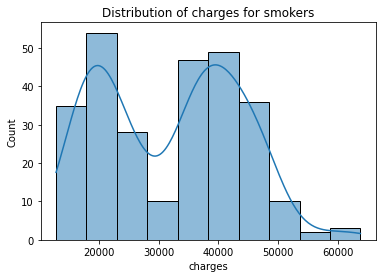

In [50]:
smoker_df = insurance_df[insurance_df['smoker'] == True]

# Plot charges of smokers

_ = sns.histplot(smoker_df, x='charges', kde=True).set_title("Distribution of charges for smokers")

In order to see what seperates the two peeks in charge amounts, we can split the data along a suitable value, in this case 30 thousand USD and plot the seperate features for each subset and see what the differences are. According to the correlation matrix, age and BMI have high correlation with charges so these will be plotted.

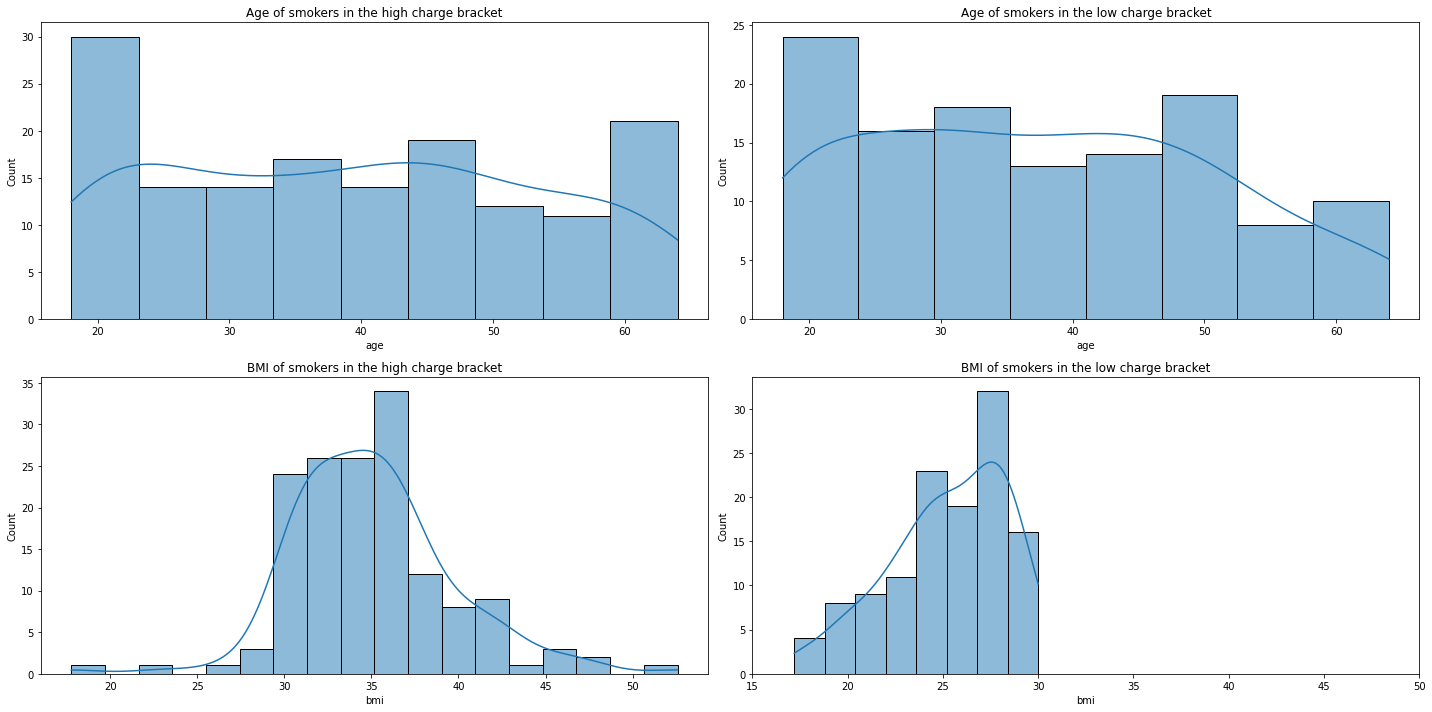

In [106]:
smoker_high_charge = smoker_df[smoker_df['charges'] >= 30000]
smoker_low_charge = smoker_df[smoker_df['charges'] < 30000]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))

ah = sns.histplot(data = smoker_high_charge, x='age', kde=True, ax=axs[0, 0])
al = sns.histplot(data = smoker_low_charge, x='age', kde=True, ax=axs[0, 1])

ah.set_title("Age of smokers in the high charge bracket")
al.set_title("Age of smokers in the low charge bracket")

bh = sns.histplot(data = smoker_high_charge, x='bmi', kde=True, ax=axs[1, 0])
bl = sns.histplot(data = smoker_low_charge, x='bmi', kde=True, ax=axs[1, 1])

bh.set_title("BMI of smokers in the high charge bracket")
bl.set_title("BMI of smokers in the low charge bracket")

bl.set_xlim(15, 50)

fig.tight_layout()
plt.show()

As can be seen above there is no significant difference in age between the peaks but, in the lower peak of charges for smokers, there are no patients with a BMI of over 30. Therefore, when `smoker=True`, the factor that indicates a higher claim amount is BMI. 

# Question 2

## 2.1

In [52]:
# Parsing fetures from features.txt and reading in text file

path = "./datasets_2022/UCI HAR Dataset/"

features = []

with open(path + "features.txt") as f:
    file = f.read()
    lines = file.splitlines(keepends=False)
    for l in lines:
        features.append(l.split(" ")[1])

x_train = pd.read_fwf(path + "train/X_train.txt")
x_train.columns = features
x_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
2,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
3,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
4,0.277199,-0.010098,-0.105137,-0.997335,-0.990487,-0.995420,-0.997627,-0.990218,-0.995549,-0.942469,...,0.019953,-0.545410,-0.844619,0.082632,-0.143439,0.275041,-0.368224,-0.849632,0.184823,-0.042126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7347,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7348,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7349,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [53]:
def get_label(x):
    return labels[int(x)]

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

y_train = pd.read_csv(path+"train/y_train.txt", sep='\n')
y_train.columns = ['labels']
y_train['labels'] = pd.to_numeric(y_train['labels']) - 1
y_train['label_eng'] = y_train['labels'].apply(get_label)
y_train

,labels,label_eng
0,4,STANDING
1,4,STANDING
2,4,STANDING
3,4,STANDING
4,4,STANDING
...,...,...
7346,1,WALKING_UPSTAIRS
7347,1,WALKING_UPSTAIRS
7348,1,WALKING_UPSTAIRS
7349,1,WALKING_UPSTAIRS


In [54]:
sub_train = pd.read_csv(path+"train/subject_train.txt", sep='\n')
sub_train.columns = ['subject']
sub_train['subject'] = pd.to_numeric(sub_train['subject'])
sub_train

,subject
0,1
1,1
2,1
3,1
4,1
...,...
7346,30
7347,30
7348,30
7349,30


In [55]:
# Parsing fetures from features.txt and reading in text file

path = "./datasets_2022/UCI HAR Dataset/"

features = []

with open(path + "features.txt") as f:
    file = f.read()
    lines = file.splitlines(keepends=False)
    for l in lines:
        features.append(l.split(" ")[1])

x_test = pd.read_fwf(path + "test/X_test.txt")
x_test.columns = features
x_test

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898
1,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346
2,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,0.116695,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108
3,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.121711,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857
4,0.279220,-0.018620,-0.113902,-0.994455,-0.970417,-0.965316,-0.994585,-0.969481,-0.965897,-0.937856,...,0.083603,-0.493517,-0.857565,-0.095681,0.048849,0.760684,-0.072216,-0.689816,0.294896,-0.068471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2941,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784
2942,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412
2943,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.066249,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184
2944,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.046467,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563


In [56]:
def get_label(x):
    return labels[int(x)]

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

y_test = pd.read_csv(path+"test/y_test.txt", sep='\n')
y_test.columns = ['labels']
y_test['labels'] = pd.to_numeric(y_train['labels']) - 1
y_test['label_eng'] = y_train['labels'].apply(get_label)
y_test

,labels,label_eng
0,3,STANDING
1,3,STANDING
2,3,STANDING
3,3,STANDING
4,3,STANDING
...,...,...
2941,4,LAYING
2942,4,LAYING
2943,4,LAYING
2944,4,LAYING


In [57]:
sub_test = pd.read_csv(path+"test/subject_test.txt", sep='\n')
sub_test.columns = ['subject']
sub_test['subject'] = pd.to_numeric(sub_train['subject'])
sub_test

,subject
0,1
1,1
2,1
3,1
4,1
...,...
2941,16
2942,16
2943,16
2944,16


Need to read test set, subject parsing seems broken so other ones are probably as well. Maybe do it manually? Line by line will be slow though. Can also convert dataset to csv. Need proper user data for identifying users. Question won't take too long compared to 3.

#### 2.1.1

In [58]:
x_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,...,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000,7351.000000
mean,0.274486,-0.017695,-0.109138,-0.605385,-0.510873,-0.604712,-0.630463,-0.526845,-0.606107,-0.468541,...,0.125321,-0.307010,-0.625282,0.008700,0.002182,0.008790,-0.005979,-0.489499,0.058577,-0.056514
std,0.070266,0.040813,0.056638,0.448742,0.502649,0.418700,0.424080,0.485946,0.414133,0.544556,...,0.251000,0.321033,0.307603,0.336807,0.448337,0.608319,0.478008,0.511825,0.297497,0.279141
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262974,-0.024863,-0.120990,-0.992750,-0.978117,-0.980246,-0.993589,-0.978153,-0.980252,-0.936219,...,-0.023457,-0.542677,-0.845576,-0.121533,-0.289587,-0.482309,-0.376382,-0.812017,-0.017991,-0.143511
50%,0.277193,-0.017219,-0.108675,-0.946139,-0.851795,-0.859273,-0.950673,-0.856916,-0.857042,-0.881635,...,0.134060,-0.343698,-0.711726,0.009522,0.008859,0.008741,-0.000213,-0.709396,0.182096,0.003201
75%,0.288449,-0.010781,-0.097793,-0.242725,-0.034219,-0.262290,-0.292672,-0.066683,-0.265598,-0.017129,...,0.289106,-0.126961,-0.503852,0.150935,0.292905,0.506204,0.359381,-0.508973,0.248356,0.107699
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


#### 2.1.2

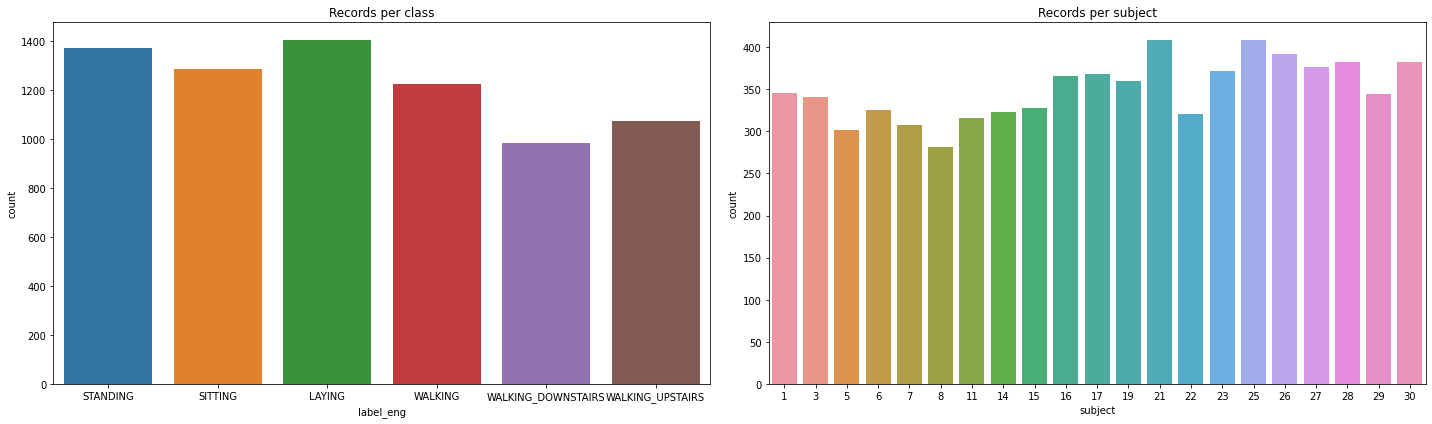

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))


_ = sns.countplot(data = y_train, x='label_eng', ax=axs[0]).set_title('Records per class')
_ = sns.countplot(data = sub_train, x='subject', ax=axs[1]).set_title('Records per subject')

fig.tight_layout()
plt.show()

#### 2.1.3

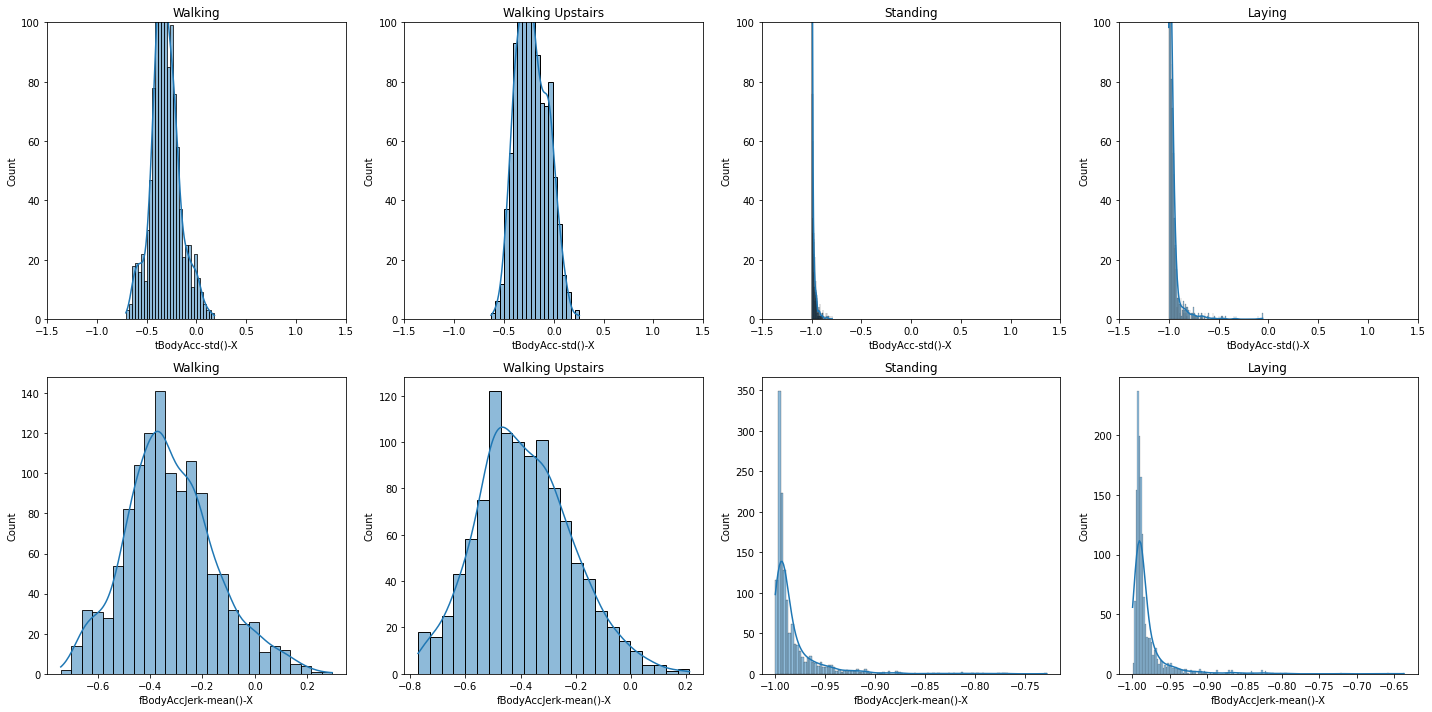

In [60]:
walking = x_train[y_train['label_eng'] == 'WALKING']
walking_up = x_train[y_train['label_eng'] == 'WALKING_UPSTAIRS']

standing = x_train[y_train['label_eng'] == 'STANDING']
laying = x_train[y_train['label_eng'] == 'LAYING']


fig, axs = plt.subplots(2, 4, figsize=(20, 10))

ax = axs.ravel()

wa = sns.histplot(data = walking, x='tBodyAcc-std()-X', ax=ax[0], kde=True)
wua = sns.histplot(data = walking_up, x='tBodyAcc-std()-X', ax=ax[1], kde=True)

sa = sns.histplot(data = standing, x='tBodyAcc-std()-X', ax=ax[2], kde=True)
la = sns.histplot(data = laying, x='tBodyAcc-std()-X', ax=ax[3], kde=True)


wj = sns.histplot(data = walking, x='fBodyAccJerk-mean()-X', ax=ax[4], kde=True)
wuj = sns.histplot(data = walking_up, x='fBodyAccJerk-mean()-X', ax=ax[5], kde=True)

sj = sns.histplot(data = standing, x='fBodyAccJerk-mean()-X', ax=ax[6], kde=True)
lj = sns.histplot(data = laying, x='fBodyAccJerk-mean()-X', ax=ax[7], kde=True)



wa.set_xlim([-1.5, 1.5])
wa.set_ylim([0, 100])
wa.set_title("Walking")

wua.set_xlim([-1.5, 1.5])
wua.set_ylim([0, 100])
wua.set_title("Walking Upstairs")


sa.set_xlim([-1.5, 1.5])
sa.set_ylim([0, 100])
sa.set_title("Standing")

la.set_xlim([-1.5, 1.5])
la.set_ylim([0, 100])
la.set_title("Laying")




wj.set_title("Walking")
wuj.set_title("Walking Upstairs")

sj.set_title("Standing")
lj.set_title("Laying")

fig.tight_layout()
plt.show()

Both of the features, `tBodyAcc-std()-X`, and `fBodyAccJerk-mean()-X`, show clear seperation. In the dynamic movements, `WALKING` and `WALKING UPSTAIRS`, the variables cluster around values with a smaller magnitude than in the static movements, `STANDING` and `LAYING`.

#### 2.1.4

A simple rule, based off the visualisations above could be 

```
if fBodyAccJerk-mean()-X <= -0.8 AND tBodyAcc-std()-X <= -0.8:
    STATIC
else:
    DYNAMIC
```

#### 2.1.5

In [61]:
y_test['prediction'] = np.where((x_test['fBodyAccJerk-mean()-X'] <= -0.8) & (x_test['tBodyAcc-std()-X'] <= -0.8) , 'STATIC', 'DYNAMIC')

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]


pred_static = y_test[y_test['prediction'] == 'STATIC']
pred_dynamic = y_test[y_test['prediction'] == 'DYNAMIC']

correct = len(pred_static[pred_static['label_eng'].isin(['STANDING', 'SITTING', 'LAYING'])]) + len(pred_dynamic[pred_dynamic['label_eng'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])])

print("Accuracy:", correct/len(y_test))


Accuracy: 0.4484046164290563


Using the simple rule defined above, the test accuracy would be 44.84%

#### 2.1.6

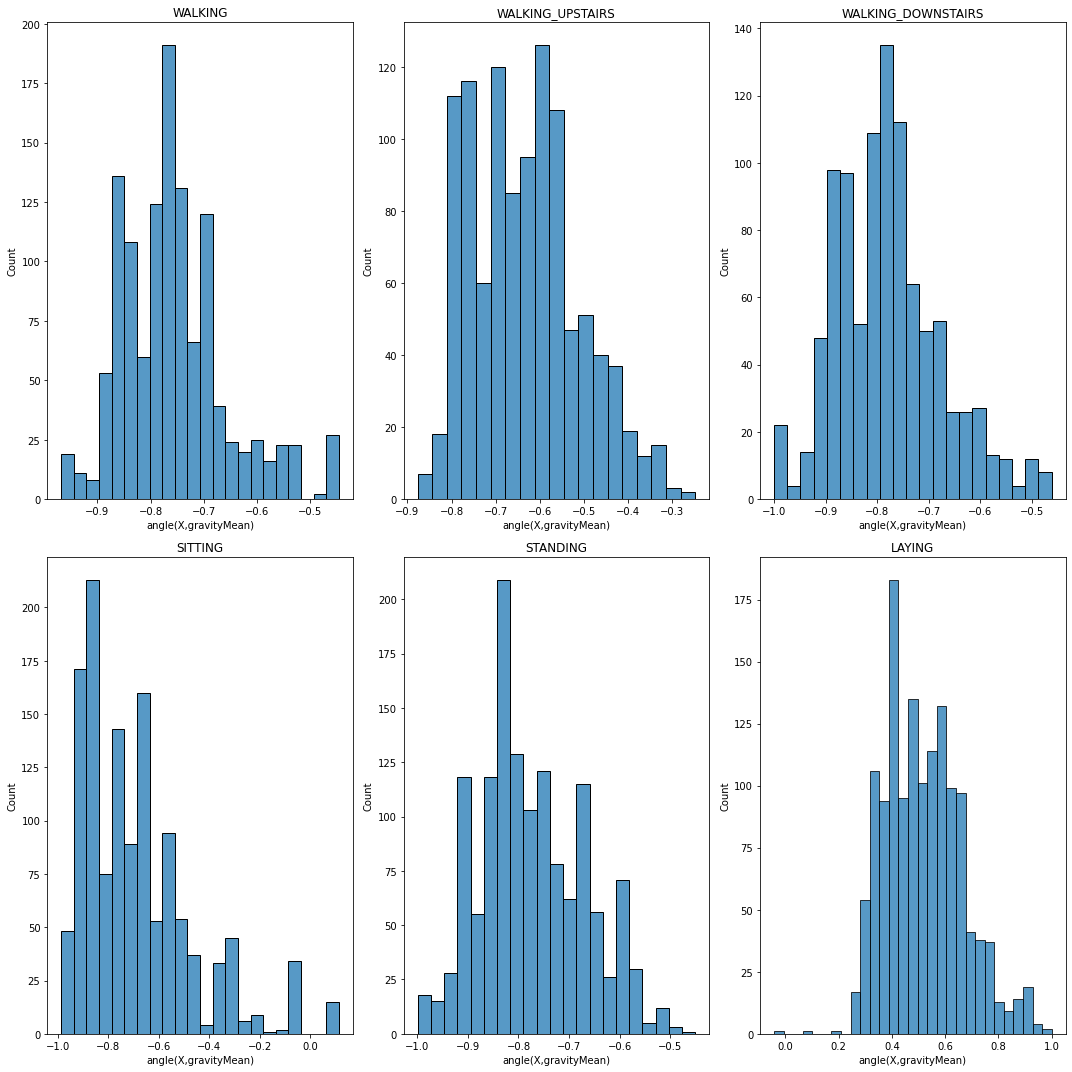

In [62]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
ax = axs.ravel()

walking = x_train[y_train['label_eng'] == 'WALKING']
sns.histplot(data = walking, x='angle(X,gravityMean)', ax=ax[0]).set_title('WALKING')
walking_upstairs = x_train[y_train['label_eng'] == 'WALKING_UPSTAIRS']
sns.histplot(data = walking_upstairs, x='angle(X,gravityMean)', ax=ax[1]).set_title('WALKING_UPSTAIRS')
walking_downstairs = x_train[y_train['label_eng'] == 'WALKING_DOWNSTAIRS']
sns.histplot(data = walking_downstairs, x='angle(X,gravityMean)', ax=ax[2]).set_title('WALKING_DOWNSTAIRS')
sitting = x_train[y_train['label_eng'] == 'SITTING']
sns.histplot(data = sitting, x='angle(X,gravityMean)', ax=ax[3]).set_title('SITTING')
standing = x_train[y_train['label_eng'] == 'STANDING']
sns.histplot(data = standing, x='angle(X,gravityMean)', ax=ax[4]).set_title('STANDING')
laying = x_train[y_train['label_eng'] == 'LAYING']
sns.histplot(data = laying, x='angle(X,gravityMean)', ax=ax[5]).set_title('LAYING')


fig.tight_layout()
plt.show()

As can be seem above, for all classes except LAYING, angle(X, gravityMean) is $< 0$ while it is $>0$ for datapoints in LAYING 

#### 2.1.7

```
if angle(X, gravityMean) < 0:
    NOT LAYING
else:
    LAYING
```

#### 2.1.8

In [63]:
y_test['prediction'] = np.where(x_test['angle(X,gravityMean)'] < 0, 'OTHER', 'LAYING')

labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]


pred_other = y_test[y_test['prediction'] == 'OTHER']
pred_lay = y_test[y_test['prediction'] == 'LAYING']

correct = len(pred_lay[pred_lay['label_eng'] == 'LAYING']) + len(pred_other[~(pred_other['label_eng'] == 'LAYING')])

print("Accuracy:", correct/len(y_test))

Accuracy: 0.6948404616429056


The accuracy using the simple rule defined above is 69.48%

#### 2.1.9

In [64]:
scaler = StandardScaler()


pca2 = PCA(n_components=2)
pca5 = PCA(n_components=5)
pca10 = PCA(n_components=10)

x2 = pca2.fit_transform(scaler.fit_transform(x_train))
x5 = pca5.fit_transform(scaler.fit_transform(x_train))
x10 = pca10.fit_transform(scaler.fit_transform(x_train))

print("Explained Variance using 2 components:", pca2.explained_variance_ratio_.sum() * 100, "%")
print("Explained Variance using 5 components:", pca5.explained_variance_ratio_.sum() * 100, "%")
print("Explained Variance using 10 components:", pca10.explained_variance_ratio_.sum() * 100, "%")

Explained Variance using 2 components: 57.35941256881405 %
Explained Variance using 5 components: 64.55367372374428 %
Explained Variance using 10 components: 70.79828626007708 %


#### 2.1.10

In [133]:
print("PC1:")

for a, b in zip(np.array(features)[np.argpartition(pca2.components_[0, :], -5)[-5:]], pca2.components_[0, np.argpartition(pca2.components_[0, :], -5)[-5:]]):
    print(a, b)

print("PC2:")

for a, b in zip(np.array(features)[np.argpartition(pca2.components_[1, :], -5)[-5:]], pca2.components_[0, np.argpartition(pca2.components_[1, :], -5)[-5:]]):
    print(a, b)


PC1:
tBodyAccJerkMag-mean() 0.05813524020422951
fBodyGyro-sma() 0.05819563561951266
tBodyAccJerk-sma() 0.05820964024812434
fBodyAccJerk-sma() 0.05823396237061306
fBodyAcc-sma() 0.0583661987307243
PC2:
tGravityAcc-arCoeff()-Y,3 0.001228173985369902
tGravityAcc-arCoeff()-Z,3 0.0004386508454465433
fBodyAcc-meanFreq()-Z -0.00928989358296071
fBodyAccMag-meanFreq() -0.0022151317856263135
tGravityAcc-arCoeff()-Z,1 0.00795097878208835


The above cell outputs the varibales with the contributions. All of these variables are based off of the acceleration data,

#### 2.1.11

In [140]:
scaler = StandardScaler()


pca2 = PCA(n_components=2)
pca5 = PCA(n_components=5)
pca10 = PCA(n_components=10)


dyn_con = y_train['label_eng'].isin(["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"])

print("-"*5 + "Dynamic Movements" + "-"*5)

x2_dyn = pca2.fit_transform(scaler.fit_transform(x_train[dyn_con]))
x5_dyn = pca5.fit_transform(scaler.fit_transform(x_train[dyn_con]))
x10_dyn = pca10.fit_transform(scaler.fit_transform(x_train[dyn_con]))

print("Explained Variance using 2 components:", pca2.explained_variance_ratio_.sum() * 100, "%")
print("Explained Variance using 5 components:", pca5.explained_variance_ratio_.sum() * 100, "%")
print("Explained Variance using 10 components:", pca10.explained_variance_ratio_.sum() * 100, "%")

print("PC1:")
for a, b in zip(np.array(features)[np.argpartition(pca2.components_[0, :], -4)[-4:]], pca2.components_[0, np.argpartition(pca2.components_[0, :], -4)[-4:]]):
    print(a, b)
print("PC2:")
for a, b in zip(np.array(features)[np.argpartition(pca2.components_[1, :], -4)[-4:]], pca2.components_[0, np.argpartition(pca2.components_[1, :], -4)[-4:]]):
    print(a, b)

print("-"*5 + "Static Movements" + "-"*5)

x2_static = pca2.fit_transform(scaler.fit_transform(x_train[~dyn_con]))
x5_static = pca5.fit_transform(scaler.fit_transform(x_train[~dyn_con]))
x10_static = pca10.fit_transform(scaler.fit_transform(x_train[~dyn_con]))

print("Explained Variance using 2 components:", pca2.explained_variance_ratio_.sum() * 100, "%")
print("Explained Variance using 5 components:", pca5.explained_variance_ratio_.sum() * 100, "%")
print("Explained Variance using 10 components:", pca10.explained_variance_ratio_.sum() * 100, "%")

print("PC1:")
for a, b in zip(np.array(features)[np.argpartition(pca2.components_[0, :], -4)[-4:]], pca2.components_[0, np.argpartition(pca2.components_[0, :], -4)[-4:]]):
    print(a, b)
print("PC2:")
for a, b in zip(np.array(features)[np.argpartition(pca2.components_[1, :], -4)[-4:]], pca2.components_[0, np.argpartition(pca2.components_[1, :], -4)[-4:]]):
    print(a, b)

-----Dynamic Movements-----
Explained Variance using 2 components: 38.07667162430083 %
Explained Variance using 5 components: 51.758925955325296 %
Explained Variance using 10 components: 60.684071255520564 %
PC1:
tBodyAccJerkMag-sma() 0.07400863199752399
tBodyAccJerkMag-energy() 0.07423621173262332
fBodyAccJerk-sma() 0.07459493178821194
tBodyAccJerk-sma() 0.07430619771187769
PC2:
fBodyAcc-bandsEnergy()-1,24 0.02946298794829116
fBodyAcc-std()-Z 0.019496161313517658
fBodyAcc-bandsEnergy()-1,8 0.00784317564551922
fBodyAcc-bandsEnergy()-1,16 0.02168429075812424
-----Static Movements-----
Explained Variance using 2 components: 45.165056026698906 %
Explained Variance using 5 components: 57.33652799892449 %
Explained Variance using 10 components: 66.06999855494531 %
PC1:
tBodyAccJerkMag-mean() 0.06414290701122993
tBodyAccJerk-sma() 0.06419911070257153
fBodyAccJerk-sma() 0.06467934290006866
fBodyGyro-sma() 0.06480482994955894
PC2:
tBodyGyroMag-arCoeff()1 -0.02469995023161886
tBodyAccMag-arCoef

When performed seperatly for static and dynamic movements, more components are required to explain the variance. Using 2 components before, about 57% of variance was explained. Using 2 components now only explains 38% for dynamic movements and 45% for static movements. The variables that contribute the most for dymanic movements are:

```
PC1:
tBodyAccJerkMag-sma() 0.07400863199752399
tBodyAccJerkMag-energy() 0.07423621173262332
fBodyAccJerk-sma() 0.07459493178821194
tBodyAccJerk-sma() 0.07430619771187769
PC2:
fBodyAcc-bandsEnergy()-1,24 0.02946298794829116
fBodyAcc-std()-Z 0.019496161313517658
fBodyAcc-bandsEnergy()-1,8 0.00784317564551922
fBodyAcc-bandsEnergy()-1,16 0.0216842907581224
```

And static movements:

```
PC1:
tBodyAccJerkMag-mean() 0.06414290701122993
tBodyAccJerk-sma() 0.06419911070257153
fBodyAccJerk-sma() 0.06467934290006866
fBodyGyro-sma() 0.06480482994955894
PC2:
tBodyGyroMag-arCoeff()1 -0.02469995023161886
tBodyAccMag-arCoeff()1 -0.034427688067134
fBodyAccMag-meanFreq() -0.030570233905504188
tGravityAccMag-arCoeff()1 -0.034427688067134
```

## 2.2

#### 2.2.1

In [141]:
@ignore_warnings(category=ConvergenceWarning)
def fit(model, name=""):
    start = time.time()
    model.fit(x_train, y_train['labels'])
    end = time.time()
    print("{} took {} seconds to train".format(name, end-start))

def test(model, name=""):
    y_pred = model.predict(x_test)
    print("{} scored {}".format(name, f1_score(y_test['labels'], y_pred, average='weighted')))

# Setting up 3 baseline models: Random Forest, Logistic Regression, Support Vector Machine

rfc = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=10)
lr = LogisticRegression(random_state=42)
svm = SVC(gamma='auto', random_state=42)

fit(rfc, "Random Forest")
test(rfc, "Random Forest")

print("")

fit(svm, "Support Vector Machine")
test(svm, "Support Vector Machine")

print("")

fit(lr, "Logistic Regression")
test(lr, "Logistic Regression")

Random Forest took 17.676998138427734 seconds to train
Random Forest scored 0.14912940274002928

Support Vector Machine took 1.243004322052002 seconds to train
Support Vector Machine scored 0.1523051038333698

Logistic Regression took 1.3284978866577148 seconds to train
Logistic Regression scored 0.15048886551755722


#### 2.2.2

In [142]:
@ignore_warnings(category=ConvergenceWarning)
def fit(model, name=""):
    start = time.time()
    model.fit(x_train, y_train['dyn'])
    end = time.time()
    print("{} took {} seconds to train".format(name, end-start))

def test(model, name=""):
    y_pred = model.predict(x_test)
    print("{} scored {}".format(name, f1_score(y_test['dyn'], y_pred, average='weighted')))

y_train['dyn'] = np.where(y_train['label_eng'].isin(["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]), 1, 0)
y_test['dyn'] = np.where(y_test['label_eng'].isin(["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]), 1, 0)


# Setting up 3 baseline models: Random Forest, Logistic Regression, Support Vector Machine

rfc = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=10)
lr = LogisticRegression(random_state=42)
svm = SVC(gamma='auto', random_state=42)

fit(rfc, "Random Forest")
test(rfc, "Random Forest")

print("")

fit(svm, "Support Vector Machine")
test(svm, "Support Vector Machine")

print("")

fit(lr, "Logistic Regression")
test(lr, "Logistic Regression")

Random Forest took 4.91599702835083 seconds to train
Random Forest scored 0.4461329414640384

Support Vector Machine took 0.29850077629089355 seconds to train
Support Vector Machine scored 0.4468338468738166

Logistic Regression took 0.42949724197387695 seconds to train
Logistic Regression scored 0.44648346513971754


In [143]:
y_test['prediction'] = np.where((x_test['fBodyAccJerk-mean()-X'] <= -0.8) & (x_test['tBodyAcc-std()-X'] <= -0.8) , 'STATIC', 'DYNAMIC')
y_test['true'] = np.where(y_test['label_eng'].isin(['STANDING', 'SITTING', 'LAYING']), 'STATIC', 'DYNAMIC')

print("F1 score: {}".format(f1_score(y_test['true'], y_test['prediction'], average='weighted')))

F1 score: 0.4483641833595872


The simple rule defined earlier achieves a very similar score to the baseline models, with an F1 score of 0.4483641833595872 for teh simple rule, and around 0.446 for the other models.

## 2.3

#### 2.3.1

In [70]:
def mutual_info_selection(num):
    selector = SelectKBest(mutual_info_classif, k=num)
    _ = selector.fit_transform(x_train, y_train['labels'])

    cols = selector.get_support(indices=True)
    return x_train.columns[cols].values

col5 = mutual_info_selection(5)
col10 = mutual_info_selection(10)
col50= mutual_info_selection(50)
col100 = mutual_info_selection(100)

In [71]:
@ignore_warnings(category=ConvergenceWarning)
def fit(model, name, cols):
    start = time.time()
    model.fit(x_train[cols], y_train['labels'])
    end = time.time()
    print("{} took {} seconds to train".format(name, end-start))

def test(model, name, cols):
    y_pred = model.predict(x_test[cols])
    print("{} scored {}".format(name, f1_score(y_test['labels'], y_pred, average='weighted')))

# Setting up 3 baseline models: Random Forest, Logistic Regression, Support Vector Machine

rfc = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=10)
lr = LogisticRegression(random_state=42)
svm = SVC(gamma='auto', random_state=42)

In [72]:
fit(rfc, "Random Forest using 5 features", col5)
test(rfc, "Random Forest using 5 features", col5)
fit(rfc, "Random Forest using 10 features", col10)
test(rfc, "Random Forest using 10 features", col10)
fit(rfc, "Random Forest using 50 features", col50)
test(rfc, "Random Forest using 50 features", col50)
fit(rfc, "Random Forest using 100 features", col100)
test(rfc, "Random Forest using 100 features", col100)

Random Forest using 5 features took 1.8719987869262695 seconds to train
Random Forest using 5 features scored 0.14745981774893013
Random Forest using 10 features took 2.7779977321624756 seconds to train
Random Forest using 10 features scored 0.14628523328487714
Random Forest using 50 features took 5.525998592376709 seconds to train
Random Forest using 50 features scored 0.15093383576569125
Random Forest using 100 features took 7.896499872207642 seconds to train
Random Forest using 100 features scored 0.15240503924336585


For the Random Forest model, 50 features achieved a much higher score over 10 features, but 100 features did not improve the performance of the model much. The training time however, was reduced significantly for all subsets of the features. The F1 score was reduced significantly however, resulting in much lower accuracy.

In [73]:
fit(svm, "Support Vector Machine using 5 features", col5)
test(svm, "Support Vector Machine using 5 features", col5)
fit(svm, "Support Vector Machine using 10 features", col10)
test(svm, "Support Vector Machine using 10 features", col10)
fit(svm, "Support Vector Machine using 50 features", col50)
test(svm, "Support Vector Machine using 50 features", col50)
fit(svm, "Support Vector Machine using 100 features", col100)
test(svm, "Support Vector Machine using 100 features", col100)

Support Vector Machine using 5 features took 0.33300065994262695 seconds to train
Support Vector Machine using 5 features scored 0.14859841311621494
Support Vector Machine using 10 features took 0.39749908447265625 seconds to train
Support Vector Machine using 10 features scored 0.14554853090045458
Support Vector Machine using 50 features took 0.4399998188018799 seconds to train
Support Vector Machine using 50 features scored 0.14097725033774164
Support Vector Machine using 100 features took 0.5425007343292236 seconds to train
Support Vector Machine using 100 features scored 0.14636328761103945


For the SVM, it performed the best with only 5 features, which had the lowest training time. This is likely due to the reduction of features preventing overfitting. The F1 score was reduced significantly however, resulting in much lower accuracy when compared with the baseline model.

In [74]:
fit(lr, "Logistic Regression using 5 features", col5)
test(lr, "Logistic Regression using 5 features", col5)
fit(lr, "Logistic Regression using 10 features", col10)
test(lr, "Logistic Regression using 10 features", col10)
fit(lr, "Logistic Regression using 50 features", col50)
test(lr, "Logistic Regression using 50 features", col50)
fit(lr, "Logistic Regression using 100 features", col100)
test(lr, "Logistic Regression using 100 features", col100)

Logistic Regression using 5 features took 0.1965017318725586 seconds to train
Logistic Regression using 5 features scored 0.14665620863901785
Logistic Regression using 10 features took 0.2684972286224365 seconds to train
Logistic Regression using 10 features scored 0.14517986884779552
Logistic Regression using 50 features took 0.38450098037719727 seconds to train
Logistic Regression using 50 features scored 0.14400452050039697
Logistic Regression using 100 features took 0.44050002098083496 seconds to train
Logistic Regression using 100 features scored 0.1463451048124849


The logistic regression model also performed the best with only 5 features, with the lowest training time as well. This is likely due to teh same reason: prevention of overfitting. The F1 score was reduced significantly however, resulting in much lower accuracy when compared with the baseline model.

## 2.4

#### 2.4.1

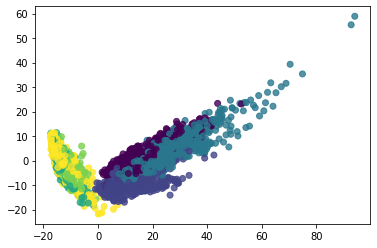

In [75]:
# PCA

scaler = StandardScaler()
pca2 = PCA(n_components=2)
x_train_pca2 = pca2.fit_transform(scaler.fit_transform(x_train))
x_test_pca2 = pca2.fit_transform(scaler.fit_transform(x_test))

plt.scatter(x_train_pca2[:, 0], x_train_pca2[:, 1], c=y_train['labels'], alpha=0.8, marker='o')
plt.show()

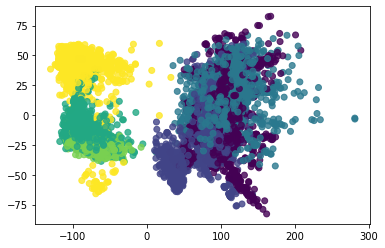

In [76]:
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", SparseEfficiencyWarning)

scaler = StandardScaler()
embedding = Isomap(n_components=2)
x_train_iso2 = embedding.fit_transform(scaler.fit_transform(x_train))
x_test_iso2 = embedding.fit_transform(scaler.fit_transform(x_test))

plt.scatter(x_train_iso2[:, 0], x_train_iso2[:, 1], c=y_train['labels'], alpha=0.8, marker='o')
plt.show()

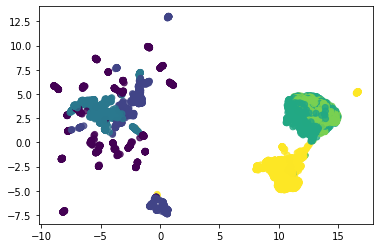

In [77]:
import umap.umap_ as umap

fit = umap.UMAP()

x_train_umap2 = fit.fit_transform(scaler.fit_transform(x_train))
x_test_umap2 = fit.fit_transform(scaler.fit_transform(x_test))

plt.scatter(x_train_umap2[:, 0], x_train_umap2[:, 1], c=y_train['labels'], alpha=0.8, marker='o')
plt.show()

In [78]:
@ignore_warnings(category=ConvergenceWarning)
def fit(model, name, data):
    start = time.time()
    model.fit(data, y_train['labels'])
    end = time.time()
    print("{} took {} seconds to train".format(name, end-start))

def test(model, name, data):
    y_pred = model.predict(data)
    print("{} scored {}".format(name, f1_score(y_test['labels'], y_pred, average='weighted')))


# Setting up 3 baseline models: Random Forest, Logistic Regression, Support Vector Machine

rfc = RandomForestClassifier(n_estimators=250, random_state=42, max_depth=10)
lr = LogisticRegression(random_state=42)
svm = SVC(gamma='auto', random_state=42)

print("Random Forest")
print("-"*30)

fit(rfc, "Random Forest (PCA)", x_train_pca2)
test(rfc, "Random Forest (PCA)", x_test_pca2)

fit(rfc, "Random Forest (ISOMAP)", x_train_iso2)
test(rfc, "Random Forest (ISOMAP)", x_test_iso2)

fit(rfc, "Random Forest (UMAP)", x_train_umap2)
test(rfc, "Random Forest (UMAP)", x_test_umap2)

print("\nLogistic Regression")
print("-"*30)

fit(lr, "Logistic Regression (PCA)", x_train_pca2)
test(lr, "Logistic Regression (PCA)", x_test_pca2)

fit(lr, "Logistic Regression (ISOMAP)", x_train_iso2)
test(lr, "Logistic Regression (ISOMAP)", x_test_iso2)

fit(lr, "Logistic Regression (UMAP)", x_train_umap2)
test(lr, "Logistic Regression (UMAP)", x_test_umap2)

print("\nSupport Vector Machine")
print("-"*30)

fit(svm, "Support Vector Machine (PCA)", x_train_pca2)
test(svm, "Support Vector Machine (PCA)", x_test_pca2)

fit(svm, "Support Vector Machine (ISOMAP)", x_train_iso2)
test(svm, "Support Vector Machine (ISOMAP)", x_test_iso2)

fit(svm, "Support Vector Machine (UMAP)", x_train_umap2)
test(svm, "Support Vector Machine (UMAP)", x_test_umap2)

Random Forest
------------------------------
Random Forest (PCA) took 1.3269991874694824 seconds to train
Random Forest (PCA) scored 0.12635432389230358
Random Forest (ISOMAP) took 1.2505004405975342 seconds to train
Random Forest (ISOMAP) scored 0.12256806319523306
Random Forest (UMAP) took 1.1044998168945312 seconds to train
Random Forest (UMAP) scored 0.05646757690669478

Logistic Regression
------------------------------
Logistic Regression (PCA) took 0.1914973258972168 seconds to train
Logistic Regression (PCA) scored 0.1172894559399121
Logistic Regression (ISOMAP) took 0.20550036430358887 seconds to train
Logistic Regression (ISOMAP) scored 0.12268979956935869
Logistic Regression (UMAP) took 0.19450044631958008 seconds to train
Logistic Regression (UMAP) scored 0.10957251346636286

Support Vector Machine
------------------------------
Support Vector Machine (PCA) took 1.6124958992004395 seconds to train
Support Vector Machine (PCA) scored 0.11797823569755995
Support Vector Machin

#### 2.4.3

In summary:

|     |                   | No Reduction        | 5 Features          | 10 Features         | 50 Features         | 100 Features        | PCA                 | ISOMAP              | UMAP                |
|-----|-------------------|---------------------|---------------------|---------------------|---------------------|---------------------|---------------------|---------------------|---------------------|
| RF  | Training Time (s) | 17.54403567314148   | 1.8510019779205322  | 2.6380066871643066  | 5.432008266448975   | 7.76952052116394    | 1.31650710105896    | 1.2335028648376465  | 1.093503713607788   |
|     | F1 Score          | 0.14912940274002928 | 0.14745981774893013 | 0.14628523328487714 | 0.15093383576569125 | 0.15240503924336585 | 0.12635432389230358 | 0.12256806319523306 | 0.08921054189086126 |
| LR  | Training Time (s) | 1.2335031032562256  | 0.19300127029418945 | 0.25150179862976074 | 0.3410017490386963  | 0.41699814796447754 | 0.1855018138885498  | 0.19749951362609863 | 0.1934981346130371  |
|     | F1 Score          | 0.15048886551755722 | 0.14665620863901785 | 0.14517986884779552 | 0.14400452050039697 | 0.1463451048124849  | 0.11595783507221352 | 0.12268979956935869 | 0.1118755445686237  |
| SVM | Training Time (s) | 1.299501657485962   | 0.33299708366394043 | 0.39100050926208496 | 0.4340023994445801  | 0.5460004806518555  | 1.573502779006958   | 6.071010112762451   | 0.18950247764587402 |
|     | F1 Score          | 0.1523051038333698  | 0.14859841311621494 | 0.14554853090045458 | 0.14097725033774164 | 0.14636328761103945 | 0.11799113021774663 | 0.11945418625666782 | 0.07177306950285466 |

All of the feature extraction/reduction tecniques reduced the training time of the baseline models, with the single exception of SVM with ISOMAP. With reduced/extracted features, however, the accuracy of the models either remained the same or decreased. PCA/ISOMAP/UMAP performed much worse when compared to the feature selection methods, which likely means that the data set cannot be accuractly described with these feature extractions. 

Depending on the model and feature extraction/selection, a similar F1 score can be achieved while significantly reducing training time. An example of this is Random Forest + 100 selected features, whcih achieved a slighgtly higher F1 score, while halving the training time of the model. However using an extraction technique such as ISOMAP, which reduces the training time by a factor of 17, results in an F1 score reduction of about 18%. If its F1 score is still good enough for the perfomance expectation of the application it is being trained for, then the reduction on training time is desireable.

The results above show that a lower training time can be achieved with a similar accuracy up to a point, and any further reduction in training time will come with a reduction in accuracy.

# Question 3

## 3.6

In [79]:
match_df = pd.read_csv('./datasets_2022/all_matches.csv')
deliver_df = pd.read_csv('./datasets_2022/all_deliveries.csv')

#### 3.6.1

In [80]:
# 'Rising Pune Supergiant' and 'Rising Pune Supergiants' are both in the dataset, but are the same team, so one needs to be replaced with the other

match_df['team1'].replace("Rising Pune Supergiant", "Rising Pune Supergiants", inplace=True)
match_df['team2'].replace("Rising Pune Supergiant", "Rising Pune Supergiants", inplace=True)
match_df['inning1_bat'].replace("Rising Pune Supergiant", "Rising Pune Supergiants", inplace=True)
match_df['inning2_bat'].replace("Rising Pune Supergiant", "Rising Pune Supergiants", inplace=True)



print("Unique Team Names:")
print(np.union1d(match_df['team1'].unique(), match_df['team2'].unique()))

Unique Team Names:
['Chennai Super Kings' 'Deccan Chargers' 'Delhi Capitals'
 'Delhi Daredevils' 'Gujarat Lions' 'Gujarat Titans' 'Kings XI Punjab'
 'Kochi Tuskers Kerala' 'Kolkata Knight Riders' 'Lucknow Super Giants'
 'Mumbai Indians' 'Pune Warriors' 'Punjab Kings' 'Rajasthan Royals'
 'Rising Pune Supergiants' 'Royal Challengers Bangalore'
 'Sunrisers Hyderabad']


"Rising Pune Supergiant" was replaced with "Rising Pune Supergiants" as they are the same team but the name was recorded incorrectly. There are 17 unique teams in the data.

#### 3.6.2

In [81]:
t1_counts = match_df.groupby('team1').count().reset_index()
t2_counts = match_df.groupby('team2').count().reset_index()

total_counts = t1_counts['team1'].copy().reset_index()
total_counts['match_counts'] = t1_counts['match_id'] + t2_counts['match_id']

win_counts = match_df.groupby('winner').count().reset_index()


total_counts['win_per'] = win_counts['match_id']/total_counts['match_counts']

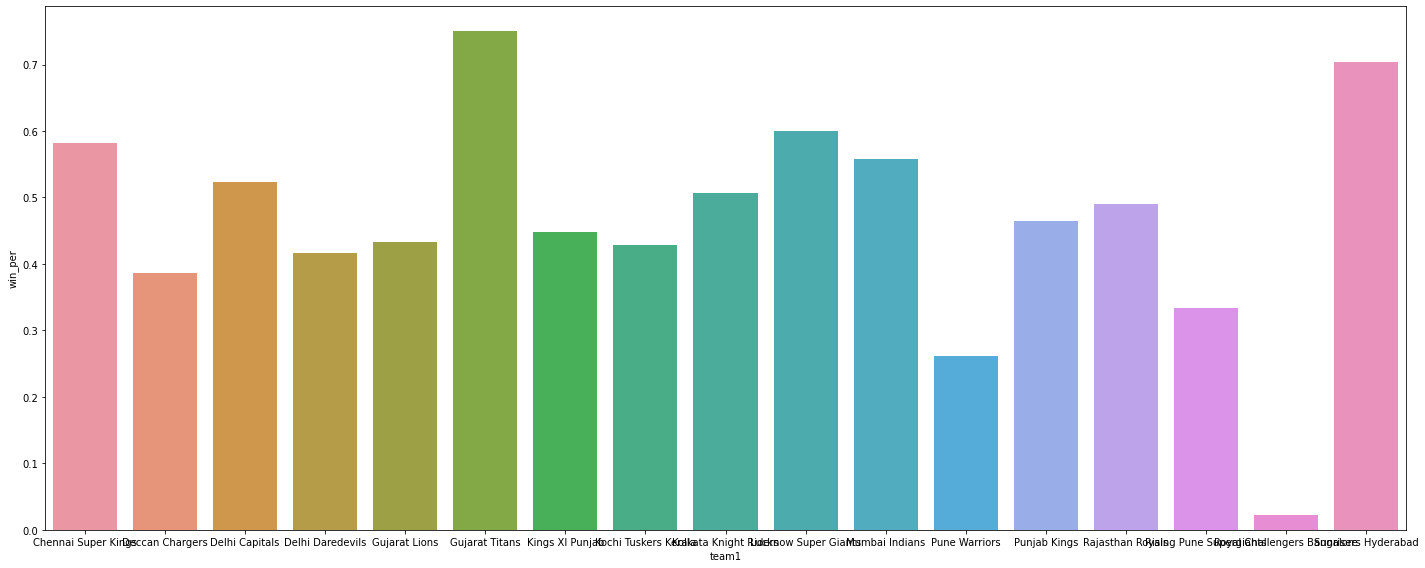

In [82]:
fig, axs = plt.subplots(figsize=(20, 8))

axs = sns.barplot(data=total_counts, x='team1', y='win_per')

fig.tight_layout()
plt.show()

#### 3.6.3 
This is a bit broken

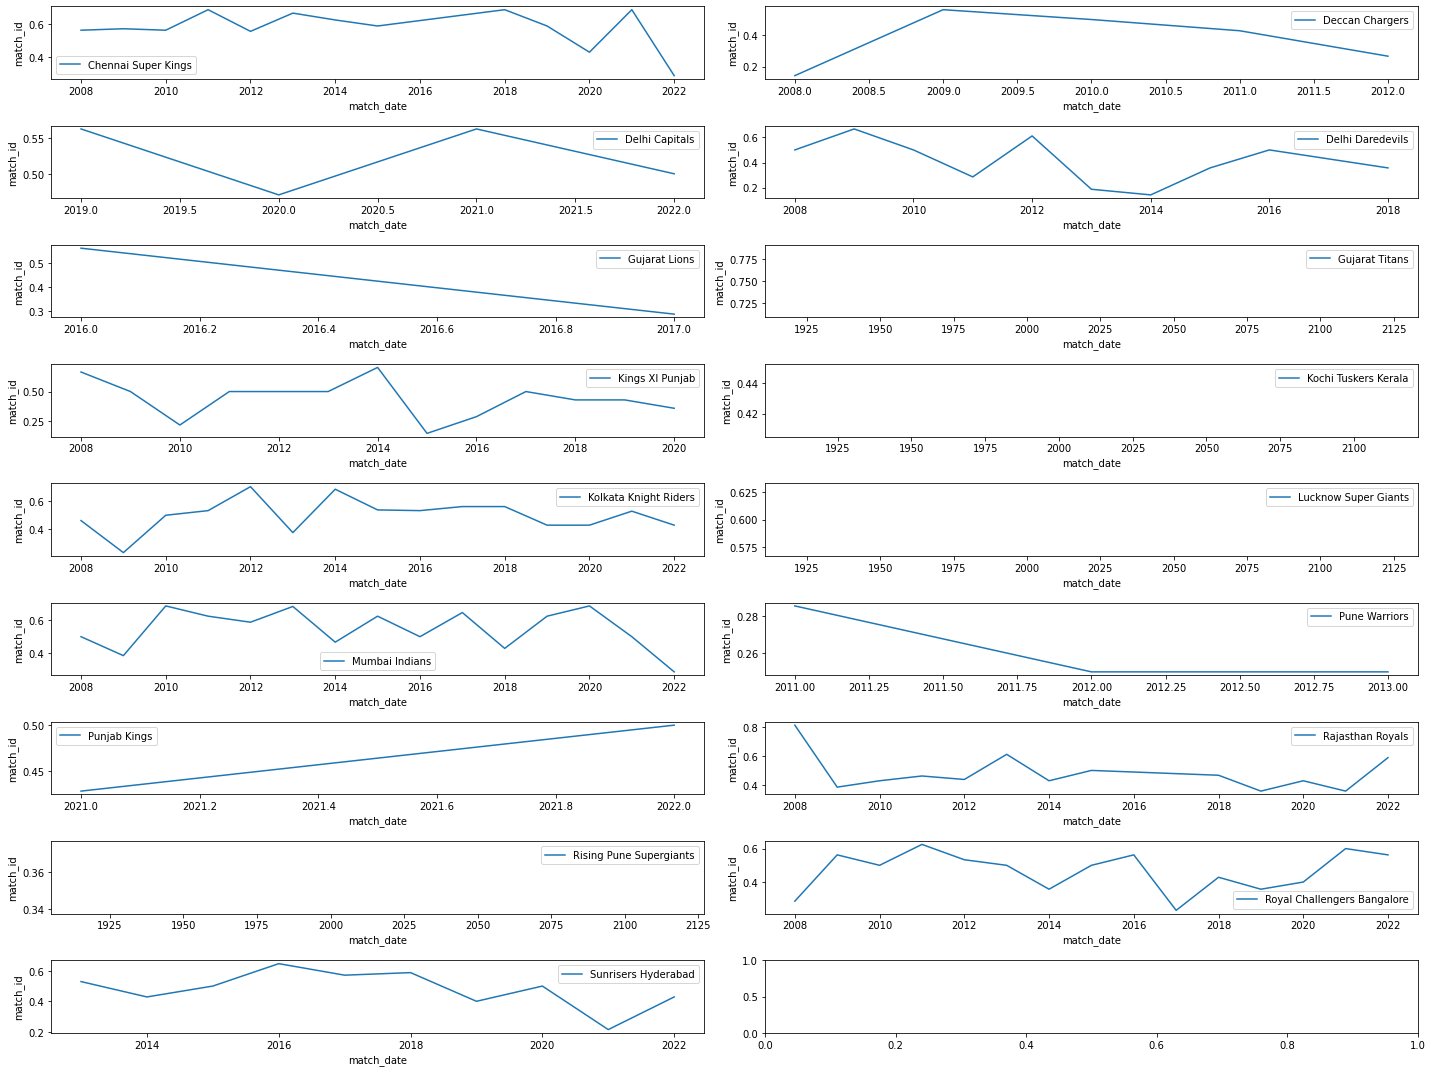

In [83]:
match_df['match_date'] = pd.to_datetime(match_df['match_date'])

teams = np.union1d(match_df['team1'].unique(), match_df['team2'].unique())

fig, axs = plt.subplots(9, 2, figsize=(20, 15))
ax = axs.ravel()

for i, team in enumerate(teams):
    team_df = match_df[(match_df['team1'] == team) | (match_df['team2'] == team)]
    # Now have values of each team, need its winrate per year
    wins = team_df[team_df['winner'] == team].groupby(team_df.match_date.dt.year).count()['match_id'].reset_index()
    totals = team_df.groupby(team_df.match_date.dt.year).count()['match_id'].reset_index()
    wins['match_id'] = wins['match_id']/totals['match_id']
    sns.lineplot(data=wins, x='match_date', y='match_id', ax=ax[i], label=team)

fig.tight_layout()
plt.show()

#### 3.6.4

In [84]:
# The last match of any given year is the finals of that year. The winner of that match is the winner of the season. (https://en.wikipedia.org/wiki/Indian_Premier_League#Tournament_format)

print("Winners of each year in descending order: ")
print(match_df.iloc[match_df.groupby(match_df.match_date.dt.year)['match_date'].idxmax()][['match_date', 'winner']])

Winners of each year in descending order: 
    match_date                 winner
869 2008-06-01       Rajasthan Royals
727 2009-05-24        Deccan Chargers
635 2010-04-25    Chennai Super Kings
644 2011-05-28    Chennai Super Kings
266 2012-05-27  Kolkata Knight Riders
862 2013-05-26         Mumbai Indians
593 2014-06-01  Kolkata Knight Riders
792 2015-05-24         Mumbai Indians
718 2016-05-29    Sunrisers Hyderabad
390 2017-05-21         Mumbai Indians
525 2018-05-27    Chennai Super Kings
158 2019-05-12         Mumbai Indians
313 2020-11-10         Mumbai Indians
595 2021-10-15    Chennai Super Kings
50  2022-05-29         Gujarat Titans


The above results were obtained by finding the winner of the last match of each respective year, which is the finals match of that season. The results match the expected winners, which can be found here: https://www.careerpower.in/ipl-winners-list.html.

#### 3.6.5

In [85]:
match_df['toss_decision'].value_counts()

field    599
bat      351
Name: toss_decision, dtype: int64

The most common decision after winning the toss is to field, with 599 field decisions and 351 bat decisions

#### 3.6.6

In [86]:
print("Number of times the toss winner also won the match:", len(match_df[match_df['toss_winner'] == match_df['winner']]))
print("As a percentage of all matches:", (len(match_df[match_df['toss_winner'] == match_df['winner']])/len(match_df))*100, "%")


Number of times the toss winner also won the match: 483
As a percentage of all matches: 50.8421052631579 %


The toss winner won the match 483 times out of a total 950 matches, or 50.84%

#### 3.6.7

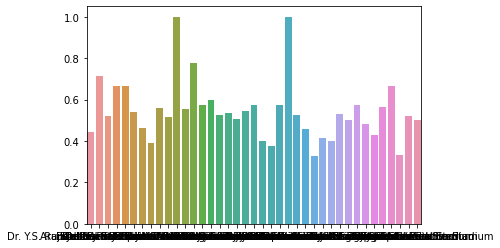

In [87]:
def extract(x):
    if x.find(',') > 0:
        return x[:x.find(',')]
    return x

match_df['toss_winner_won'] = np.where(match_df['toss_winner'] == match_df['winner'], 1, 0)

# Venues sometimes have their location after the name, which needs to be removed
match_df['venue'] = match_df['venue'].apply(extract)


t = match_df.groupby('venue')['toss_winner_won'].sum() / match_df.groupby('venue').size()

x = t.index.to_numpy()
y = t.values

_ = sns.barplot(x=x, y=y)

If you win the toss, you are slightly more likely to win the game.

## 3.7

#### 3.7.1

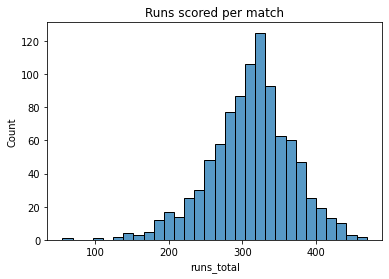

In [88]:
_ = sns.histplot(x=deliver_df.groupby('match_id')['runs_total'].sum()).set_title("Runs scored per match")

#### 3.7.2

In [89]:
match_df['total_runs'] = deliver_df.groupby('match_id')['runs_total'].sum().reset_index()['runs_total']

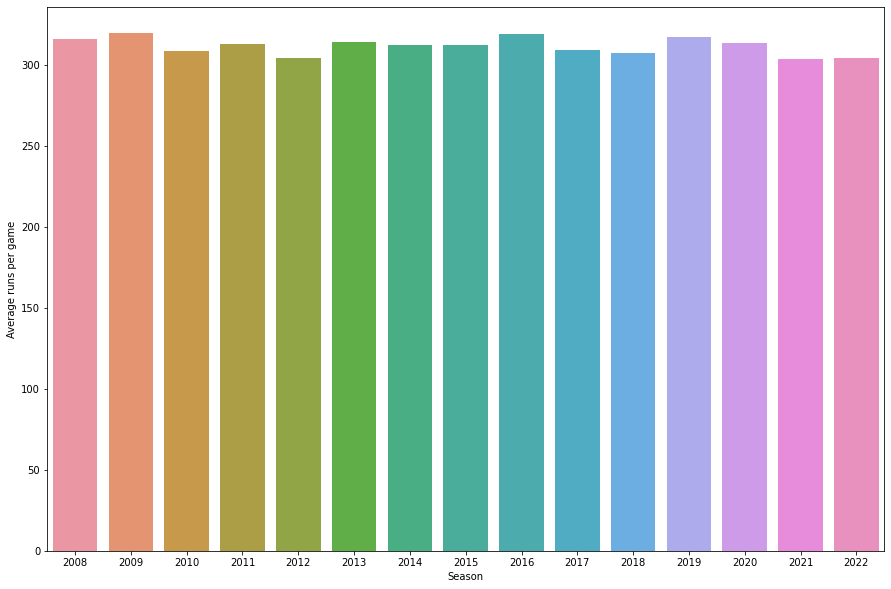

In [90]:
fig, axs = plt.subplots(figsize=(15, 10))

p = sns.barplot(data = match_df[['match_date', 'total_runs']].groupby(match_df.match_date.dt.year).mean().reset_index(), x='match_date', y='total_runs')
p.set_ylabel("Average runs per game")
p.set_xlabel("Season")
plt.show()

There is no noticable trend. Some seasons score slightly less on average, which seems to be the case for the recent seasons.

#### 3.7.3

The inning1_bat field is incorrect, so this will have to be calculated using who won the toss and what they decided

In [91]:
def bat1(team1, team2, won_toss, choice):
    if choice == "bat":
        return won_toss
    else:
        if team1 == won_toss:
            return team2
        return team1

bat_df = match_df[['match_id', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner']].copy()

# Who bats first?

bat_df['in1_bat'] = bat_df.apply(lambda x: bat1(x['team1'], x['team2'], x['toss_winner'], x['toss_decision']), axis=1)

bat_df['in1_runs'] = deliver_df[deliver_df['inning'] == 1].groupby('match_id')['runs_total'].sum().reset_index()['runs_total']


print("Percentage of games won when the innings 1 total is more than 190: ", (len(bat_df[((bat_df['winner'] == bat_df['in1_bat']) & (bat_df['in1_runs'] >= 190))])/(len(bat_df[((bat_df['winner'] != bat_df['in1_bat']) & (bat_df['in1_runs'] >= 190))])))*100)

Percentage of games won when the innings 1 total is more than 190:  61.76470588235294


When the first innings total is over 190, the team batting in innings 1 won 63% of the time.

#### 3.7.4

In [92]:
six_df = match_df[['match_id', 'match_date']].copy()
six_df['per_game'] = deliver_df[deliver_df['runs_batter'] == 6].groupby('match_id').count()['over'].reset_index()['over']
six_df.groupby(six_df.match_date.dt.year)['per_game'].sum().reset_index()

,match_date,per_game
0,2008,659
1,2009,673
2,2010,714
3,2011,819
4,2012,807
5,2013,869
6,2014,680
7,2015,641
8,2016,712
9,2017,626


The results are shown above, where `match_date` is the season and `per_game` is the total amount of 6s.

#### 3.7.5

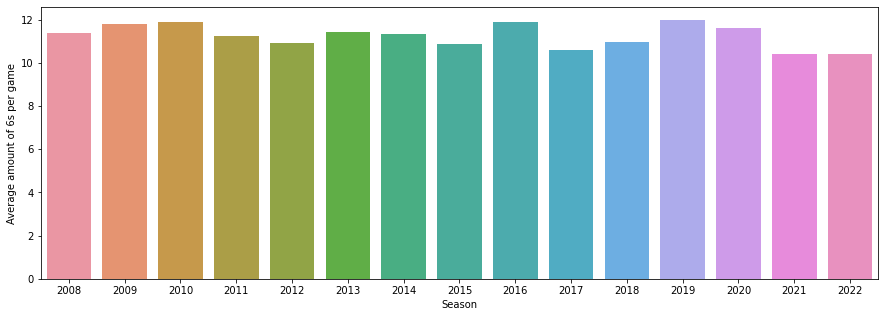

In [93]:
fig, axs = plt.subplots(figsize=(15, 5))

p = sns.barplot(data = six_df.groupby(six_df.match_date.dt.year)['per_game'].mean().reset_index(), x='match_date', y='per_game')
p.set_ylabel("Average amount of 6s per game")
p.set_xlabel("Season")

plt.show()

Later seasons do not have more 6s per game, on average

#### 3.7.6

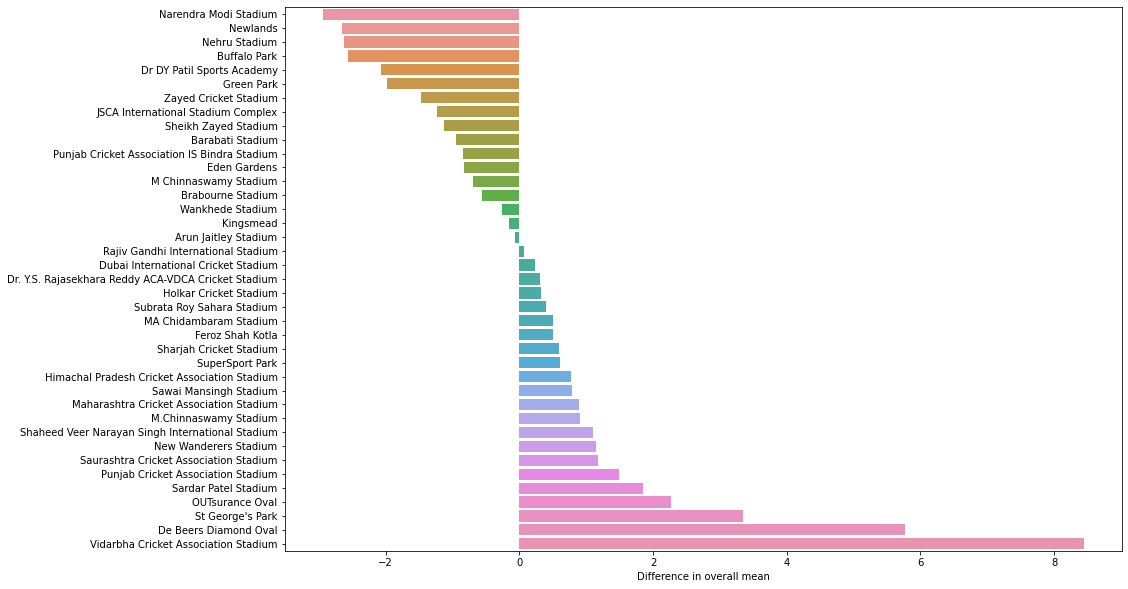

In [94]:
six_df['venue'] = match_df['venue']

overall = six_df['per_game'].mean()

per = six_df.groupby('venue')['per_game'].mean()

lab = (per - overall).sort_values().index.to_numpy()
val = (per - overall).sort_values().values

fig, axs = plt.subplots(figsize=(15, 10))

p = sns.barplot(x = val, y = lab)
p.set_xlabel("Difference in overall mean")

plt.show()

Vidarbha Cricket Association Stadium and De Beers Diamond Oval achieve a larger tahn average mean amount of 6s at games at these venues. This may be due to these grounds having smaller boundaries, meaning balls that would not have reached the boundary at a field such as Newlands, would do so at these venues.

## 3.8

#### 3.8.1

In [95]:
runs = deliver_df.groupby(['striker', 'match_id'])['runs_batter'].sum().reset_index()
# Contains count of each amount of run scored per batter per game
run_counts = deliver_df.groupby(['striker', 'match_id'])['runs_batter'].value_counts().unstack(fill_value=0).reset_index()

balls = deliver_df.groupby(['striker', 'match_id'])['runs_batter'].count().reset_index(name="ball_num")

#### 3.8.2

In [96]:
run_counts.groupby('striker')[6].sum().reset_index()

,striker,6
0,A Ashish Reddy,15
1,A Badoni,7
2,A Chandila,0
3,A Chopra,0
4,A Choudhary,1
...,...,...
600,Yash Dayal,0
601,Yashpal Singh,0
602,Younis Khan,0
603,Yuvraj Singh,149


In [97]:
balls

,striker,match_id,ball_num
0,A Ashish Reddy,548346,10
1,A Ashish Reddy,548352,3
2,A Ashish Reddy,548359,8
3,A Ashish Reddy,548373,4
4,A Ashish Reddy,548376,5
...,...,...,...
14224,Z Khan,980903,9
14225,Z Khan,980993,4
14226,Z Khan,1082595,1
14227,Z Khan,1082635,11


In [98]:
data = runs.groupby('striker')['runs_batter'].sum().reset_index().rename(columns={'runs_batter' : 'total_runs'})
data['total_balls'] = balls.groupby('striker')['ball_num'].sum().reset_index()['ball_num']
data['times_dismissed'] = balls.groupby('striker').count().reset_index()['ball_num']
data['strike_rate'] = (data['total_runs']/data['total_balls'])*100
data['average'] = data['total_runs']/data['times_dismissed']
data['fours'] = run_counts.groupby('striker')[4].sum().reset_index()[4]
data['sixes'] = run_counts.groupby('striker')[6].sum().reset_index()[6]

data

,striker,total_runs,total_balls,times_dismissed,strike_rate,average,fours,sixes
0,A Ashish Reddy,280,196,23,142.857143,12.173913,16,15
1,A Badoni,161,139,11,115.827338,14.636364,11,7
2,A Chandila,4,7,2,57.142857,2.000000,0,0
3,A Chopra,53,75,6,70.666667,8.833333,7,0
4,A Choudhary,25,20,3,125.000000,8.333333,1,1
...,...,...,...,...,...,...,...,...
600,Yash Dayal,0,1,1,0.000000,0.000000,0,0
601,Yashpal Singh,47,67,4,70.149254,11.750000,5,0
602,Younis Khan,3,7,1,42.857143,3.000000,0,0
603,Yuvraj Singh,2754,2207,126,124.784776,21.857143,218,149


#### 3.8.3

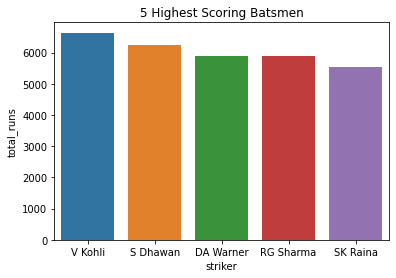

In [99]:
_ = sns.barplot(data=data.nlargest(5, ['total_runs']), x='striker', y='total_runs').set_title("5 Highest Scoring Batsmen")

#### 3.8.4

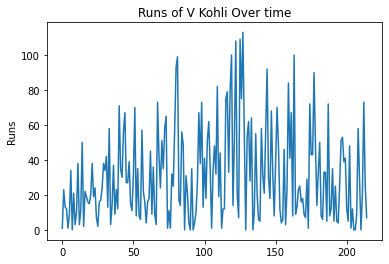

In [100]:
v = runs[runs['striker'] == data.nlargest(1, ['total_runs'])['striker'].iloc[0]]['runs_batter'].reset_index()
y = v['runs_batter'].to_numpy()
x = v.index.to_numpy()

p = sns.lineplot(x = x, y = y)
p.set_title("Runs of {} Over time".format(data.nlargest(1, ['total_runs'])['striker'].iloc[0]))
p.set_ylabel("Runs")

plt.show()

There is a lot of noise in the data, but it appears that the batter has more hgh scoring games in the later games than the initial first games. 

#### 3.8.5

Percentage of batters with an over 30 average: 2.809917355371901 %


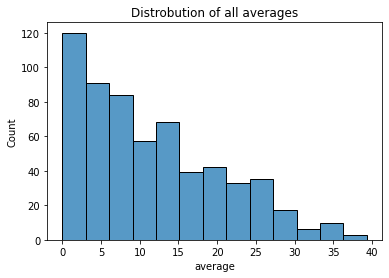

In [101]:
print("Percentage of batters with an over 30 average:", (len(data[(data['average'] >= 30) & (data['total_runs'] >= 500)])/len(data))*100, "%")

_ = sns.histplot(data, x='average').set_title("Distrobution of all averages")

Only 2,8% of batters with more than 500 total runs have maintained an average of 30 runs of more.

#### 3.8.6

In [102]:
print("Total 6s hit:")
data[['striker', 'sixes']].nlargest(10, columns='sixes')

Total 6s hit:


,striker,sixes
108,CH Gayle,359
27,AB de Villiers,253
430,RG Sharma,241
339,MS Dhoni,229
251,KA Pollard,224
569,V Kohli,219
130,DA Warner,216
493,SK Raina,204
511,SR Watson,190
452,RV Uthappa,182


In [103]:
print("Average number of 6s per game:")
run_counts.groupby('striker')[6].mean().nlargest(10).reset_index()

Average number of 6s per game:


,striker,6
0,CH Gayle,2.546099
1,AD Russell,2.160494
2,RM Patidar,1.909091
3,PD Collingwood,1.857143
4,R Powell,1.833333
5,TH David,1.777778
6,LS Livingstone,1.739130
7,DP Conway,1.714286
8,JC Buttler,1.666667
9,R Shepherd,1.666667


The number of total 6s in the IPL for a specific batsman is very different than the average 6s per game, with the excpet of CH Gayle. The average 6s per game is likely skewed by small sample sizes of matches for the batsment appearing.

## 3.9

#### 3.9.1

In [104]:
# Need to make sure out goes to bowler

outs = deliver_df[~deliver_df['how_out'].isin(['run out', 'retired hurt', 'retired out', 'obstructing the field'])].groupby(['bowler', 'match_id'])['player_dismissed'].count().reset_index()
bowled = deliver_df.groupby(['bowler', 'match_id'])['bowler'].count().reset_index(name="balls")
runs_scored = deliver_df.groupby(['bowler', 'match_id'])['runs_total'].sum().reset_index()

#### 3.9.2

In [105]:
data = outs.groupby('bowler')['player_dismissed'].sum().reset_index(name="outs_total")
data['balls_total'] = bowled.groupby('bowler')['balls'].sum().reset_index()['balls']
data['runs_total'] = runs_scored.groupby('bowler')['runs_total'].sum().reset_index()['runs_total']
data['economy'] = (data['runs_total']/data['balls_total'])*6
data['average'] = data['runs_total']/data['outs_total']
data

,bowler,outs_total,balls_total,runs_total,economy,average
0,A Ashish Reddy,18,270,400,8.888889,22.222222
1,A Badoni,2,12,12,6.000000,6.000000
2,A Chandila,11,234,245,6.282051,22.272727
3,A Choudhary,5,108,144,8.000000,28.800000
4,A Dananjaya,0,25,47,11.280000,inf
...,...,...,...,...,...,...
467,YK Pathan,42,1184,1443,7.312500,34.357143
468,YS Chahal,166,2940,3699,7.548980,22.283133
469,Yash Dayal,11,205,296,8.663415,26.909091
470,Yuvraj Singh,36,882,1091,7.421769,30.305556


#### 3.9.3

Highest Wicket Takers:
         bowler  outs_total
109    DJ Bravo         183
393  SL Malinga         170
7      A Mishra         166
468   YS Chahal         166
310   PP Chawla         157


<AxesSubplot:xlabel='bowler', ylabel='outs_total'>

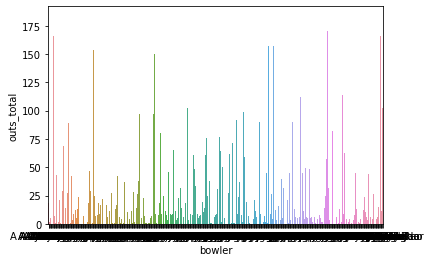

In [106]:
print("Highest Wicket Takers:")

print(data[['bowler', 'outs_total']].nlargest(5, columns='outs_total'))

sns.barplot(data = data, x='bowler', y='outs_total')

#### 3.9.4

In [107]:
data[data['balls_total'] > 120].nsmallest(5, columns='economy')

,bowler,outs_total,balls_total,runs_total,economy,average
277,Mohsin Khan,14,206,202,5.883495,14.428571
425,Sohail Tanvir,22,265,275,6.226415,12.500000
2,A Chandila,11,234,245,6.282051,22.272727
131,FH Edwards,5,150,160,6.400000,32.000000
355,Rashid Khan,112,2232,2411,6.481183,21.526786


#### 3.9.5

In [108]:
data[data['balls_total'] > 120].nsmallest(5, columns='average')

,bowler,outs_total,balls_total,runs_total,economy,average
425,Sohail Tanvir,22,265,275,6.226415,12.500000
277,Mohsin Khan,14,206,202,5.883495,14.428571
92,CK Langeveldt,13,165,199,7.236364,15.307692
444,Umar Gul,12,153,198,7.764706,16.500000
15,A Zampa,21,292,373,7.664384,17.761905


Text(0.5, 1.0, 'Economy v Average')

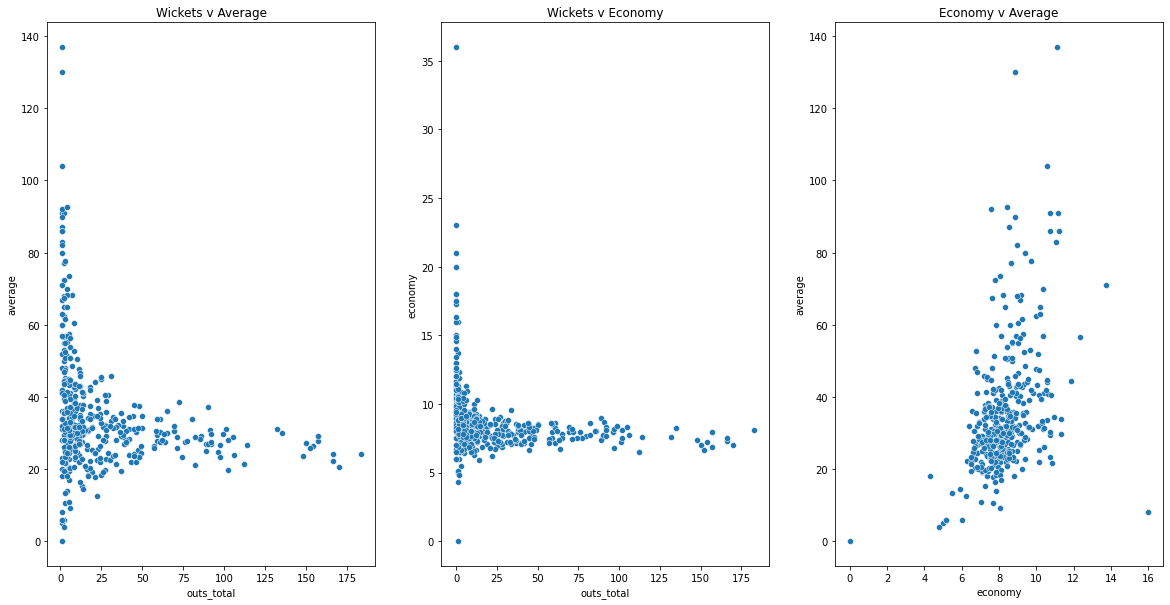

In [109]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

sns.scatterplot(data = data, x='outs_total', y='average', ax=axs[0]).set_title("Wickets v Average")
sns.scatterplot(data = data, x='outs_total', y='economy', ax=axs[1]).set_title("Wickets v Economy")
sns.scatterplot(data = data, x='economy', y='average', ax=axs[2]).set_title("Economy v Average")

#### 3.9.7

<AxesSubplot:xlabel='diff', ylabel='index'>

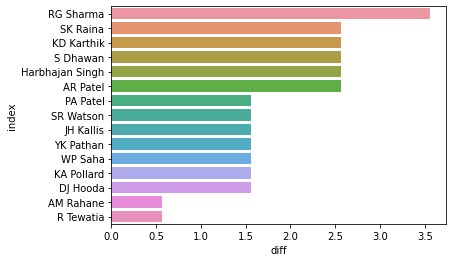

In [110]:
top = data.nlargest(1, columns='outs_total')['bowler'].values[0]

wicket_counts = deliver_df[((deliver_df['bowler'] == top) & (deliver_df['player_dismissed'].notna()))]["player_dismissed"].value_counts().reset_index(name="times_dismissed")
wicket_counts['diff'] = wicket_counts['times_dismissed'] - wicket_counts['times_dismissed'].mean()

sns.barplot(data = wicket_counts.nlargest(15, columns=['diff']), x='diff', y='index')

#### 3.9.8

In [111]:
r = deliver_df[deliver_df['bowler'] == top].groupby('striker')['runs_batter'].sum().reset_index(name="total_runs")
r.nlargest(5, columns='total_runs')

,striker,total_runs
247,V Kohli,157
103,KA Pollard,136
201,S Dhawan,132
188,RG Sharma,82
15,AD Russell,78


#### 3.9.9

In [112]:
moms_df = match_df.groupby('mom').count()['match_id'].reset_index(name="num_mom")
moms_df.nlargest(5, columns="num_mom")

,mom,num_mom
10,AB de Villiers,25
38,CH Gayle,22
48,DA Warner,18
194,RG Sharma,18
153,MS Dhoni,17


Most of these players appeared on one of the top 5 batsmen lists, which matches what would be expected.